# 🔍 Sonar Net Detection Pipeline Visualization

This notebook provides a comprehensive visualization of each step in the sonar image processing pipeline for net detection. Each step shows the transformation of the sonar image as it progresses through the processing stages.

## Pipeline Overview

The net detection pipeline consists of 8 main steps:

1. **Original Frame** - Raw sonar data (uint8 grayscale)
2. **Momentum Enhancement** - Directional momentum merge for sharper objects  
3. **Edge Detection** - Canny edge detection on enhanced image
4. **Morphological Edge Processing** - Directional morphological operations (close + dilate)
5. **Exclusion Masking** - Pixel-level prevention of unwanted merging
6. **Contour Detection** - Find contours from processed edges
7. **Contour Selection** - Select best contour based on area, elongation, and tracking
8. **Final Distance Measurement** - Distance calculation and validation

This visualization helps understand how each processing step contributes to the final net detection result.

## Setup and Configuration

In [31]:
# Centralized sonar defaults (inserted by sweep)
from utils.sonar_config import SONAR_VIS_DEFAULTS
from pathlib import Path
import utils.sonar_image_analysis as iau
from utils.sonar_config import IMAGE_PROCESSING_CONFIG
sonar_config = SONAR_VIS_DEFAULTS.copy()
# Backwards-compatible variable names used in older notebooks
RANGE_MIN_M = sonar_config['range_min_m']
RANGE_MAX_M = sonar_config['range_max_m']
DISPLAY_RANGE_MAX_M = sonar_config['display_range_max_m']

# Prefer selecting by bag ID (part of the NPZ filename) instead of a numeric index.
# Set TARGET_BAG to a substring that appears in the NPZ filename (e.g. '2024-08-22_14-29-05')
# '2024-08-22_14-47-39'
# '2024-08-22_14-29-05'
# '2024-08-20_14-31-29' HARD
TARGET_BAG = '2024-08-20_14-31-29'  # change this to your desired bag ID
from utils.sonar_config import EXPORTS_DIR_DEFAULT, EXPORTS_SUBDIRS
EXPORTS_FOLDER = Path(EXPORTS_DIR_DEFAULT)

# If you keep your raw .bag files or raw data on an external drive, point DATA_DIR there.
# Example (your external disk): /Volumes/LaCie/SOLAQUA/raw_data
DATA_DIR = Path("/Volumes/LaCie/SOLAQUA/raw_data")
print(f"Using DATA_DIR = {DATA_DIR}")

# Find NPZ files and pick the one matching TARGET_BAG
files = iau.get_available_npz_files()
if not files:
    raise FileNotFoundError(f"No NPZ files found in configured exports outputs (looked under {EXPORTS_FOLDER / EXPORTS_SUBDIRS.get('outputs','outputs')})")
matches = [p for p in files if TARGET_BAG in p.name]
if not matches:
    # Help the user by listing available NPZ files
    print(f'No NPZ file matched TARGET_BAG={TARGET_BAG!r}')
    print('Available NPZ files:')
    for i,p in enumerate(files):
        print(f'  {i}: {p.name}')
    raise ValueError(f'No NPZ file contains "{TARGET_BAG}" in its name')

# If multiple matches, choose the most recently modified one
selected = max(matches, key=lambda p: p.stat().st_mtime)
NPZ_FILE_INDEX = files.index(selected)
print(f'Selected NPZ file: {selected.name} (index={NPZ_FILE_INDEX})')

Using DATA_DIR = /Volumes/LaCie/SOLAQUA/raw_data
Selected NPZ file: 2024-08-20_14-31-29_data_cones.npz (index=8)
Selected NPZ file: 2024-08-20_14-31-29_data_cones.npz (index=8)


In [42]:
# Import required libraries for pipeline visualization
import cv2
import numpy as np
import matplotlib.pyplot as plt
from utils.sonar_image_analysis import (
    prepare_input_gray, preprocess_edges, 
    select_best_contour_core, compute_contour_features,
    SonarDataProcessor, FrameAnalysisResult,
    to_uint8_gray, get_available_npz_files, load_cone_run_npz,
    _distance_angle_from_contour
)
import utils.sonar_image_analysis as iau
from utils.sonar_config import IMAGE_PROCESSING_CONFIG, TRACKING_CONFIG

# Set the frame to analyze (you can change this)
DEMO_FRAME_INDEX = 980

print("📚 Libraries imported for pipeline visualization")
print(f"🎯 Demo frame index: {DEMO_FRAME_INDEX}")
print("✅ Ready to visualize the net detection pipeline!")

📚 Libraries imported for pipeline visualization
🎯 Demo frame index: 980
✅ Ready to visualize the net detection pipeline!


## Load Demo Frame

In [33]:
# Load the frame for pipeline demonstration
try:
    # Method 1: Try to use existing loaded NPZ data
    if 'cones' in locals() and len(cones) > DEMO_FRAME_INDEX:
        demo_frame = to_uint8_gray(cones[DEMO_FRAME_INDEX])
        print(f"✅ Loaded frame {DEMO_FRAME_INDEX} from existing NPZ data")
    else:
        # Method 2: Load from NPZ file using the utility functions
        print(f"🔄 Loading frame {DEMO_FRAME_INDEX} from NPZ file...")
        
        # Get available NPZ files
        npz_files = get_available_npz_files()
        if not npz_files:
            raise FileNotFoundError("No NPZ files found in the default directory")
        
        # Use the first NPZ file or the specified index
        npz_file_index = locals().get('NPZ_FILE_INDEX', 0)
        if npz_file_index >= len(npz_files):
            npz_file_index = 0
            print(f"⚠️ NPZ_FILE_INDEX out of range, using index 0")
        
        # Load the NPZ data
        cones, timestamps, extent, meta = load_cone_run_npz(npz_files[npz_file_index])
        
        # Check if frame index is valid
        if DEMO_FRAME_INDEX >= len(cones):
            DEMO_FRAME_INDEX = len(cones) // 2  # Use middle frame
            print(f"⚠️ Frame index out of range, using middle frame: {DEMO_FRAME_INDEX}")
        
        # Convert frame to uint8 grayscale
        demo_frame = to_uint8_gray(cones[DEMO_FRAME_INDEX])
        
        # Store variables for other cells to use
        globals()['cones'] = cones
        globals()['extent'] = extent
        globals()['DEMO_FRAME_INDEX'] = DEMO_FRAME_INDEX
        
        print(f"✅ Loaded frame {DEMO_FRAME_INDEX} from NPZ file: {npz_files[npz_file_index].name}")
    
    print(f"📐 Frame shape: {demo_frame.shape}")
    print(f"📊 Frame dtype: {demo_frame.dtype}")
    print(f"🎨 Pixel range: {demo_frame.min()} - {demo_frame.max()}")
    
    # Store the frame for other cells
    globals()['demo_frame'] = demo_frame
    
except Exception as e:
    print(f"❌ Error loading frame: {e}")
    print("💡 Troubleshooting suggestions:")
    print("   • Ensure NPZ files exist in the data directory")
    print("   • Check that the frame index is within range")
    print("   • Try running earlier cells to load data first")

✅ Loaded frame 1020 from existing NPZ data
📐 Frame shape: (700, 900)
📊 Frame dtype: uint8
🎨 Pixel range: 0 - 255


## Step 1: Original Frame Visualization

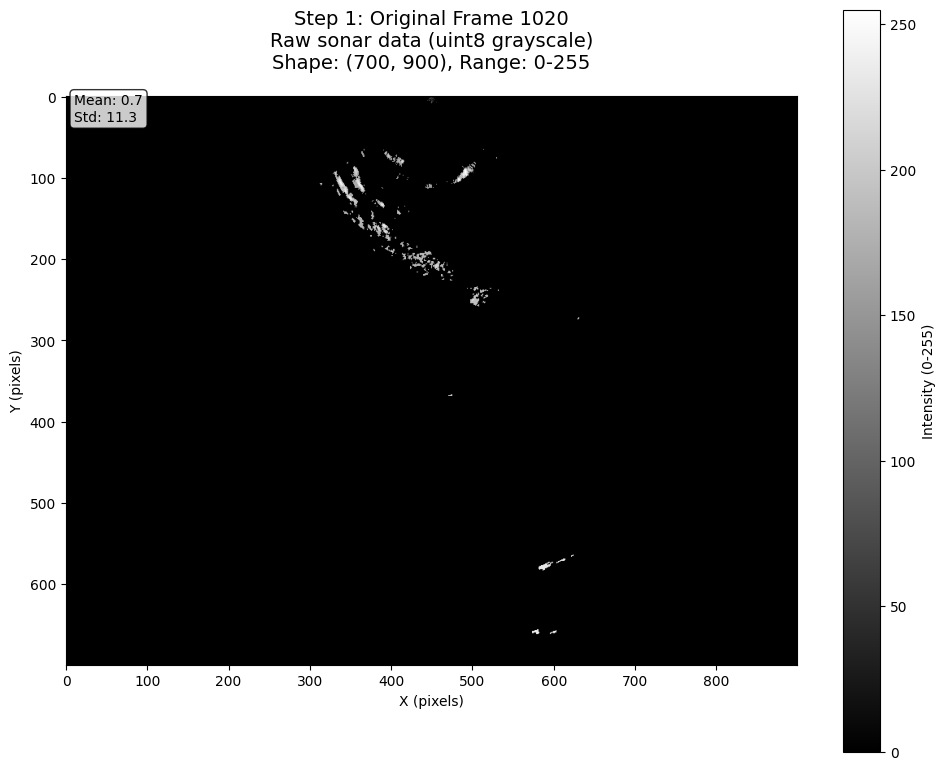

📊 Frame statistics:
   • Mean intensity: 0.67
   • Standard deviation: 11.27
   • Non-zero pixels: 2275/630000 (0.4%)


In [34]:
# STEP 1: Original Frame Visualization
if 'demo_frame' in locals():
    plt.figure(figsize=(10, 8))
    plt.imshow(demo_frame, cmap='gray', aspect='equal')
    plt.title(f'Step 1: Original Frame {DEMO_FRAME_INDEX}\n'
              f'Raw sonar data (uint8 grayscale)\n'
              f'Shape: {demo_frame.shape}, Range: {demo_frame.min()}-{demo_frame.max()}', 
              fontsize=14, pad=20)
    plt.colorbar(label='Intensity (0-255)')
    plt.xlabel('X (pixels)')
    plt.ylabel('Y (pixels)')
    
    # Add some statistics as text
    mean_intensity = np.mean(demo_frame)
    std_intensity = np.std(demo_frame)
    plt.text(10, 30, f'Mean: {mean_intensity:.1f}\nStd: {std_intensity:.1f}', 
             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
             fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    print(f"📊 Frame statistics:")
    print(f"   • Mean intensity: {mean_intensity:.2f}")
    print(f"   • Standard deviation: {std_intensity:.2f}")
    print(f"   • Non-zero pixels: {np.count_nonzero(demo_frame)}/{demo_frame.size} ({100*np.count_nonzero(demo_frame)/demo_frame.size:.1f}%)")
else:
    print("❌ Demo frame not available. Please run the previous cell first.")

## Step 2: Momentum Enhancement

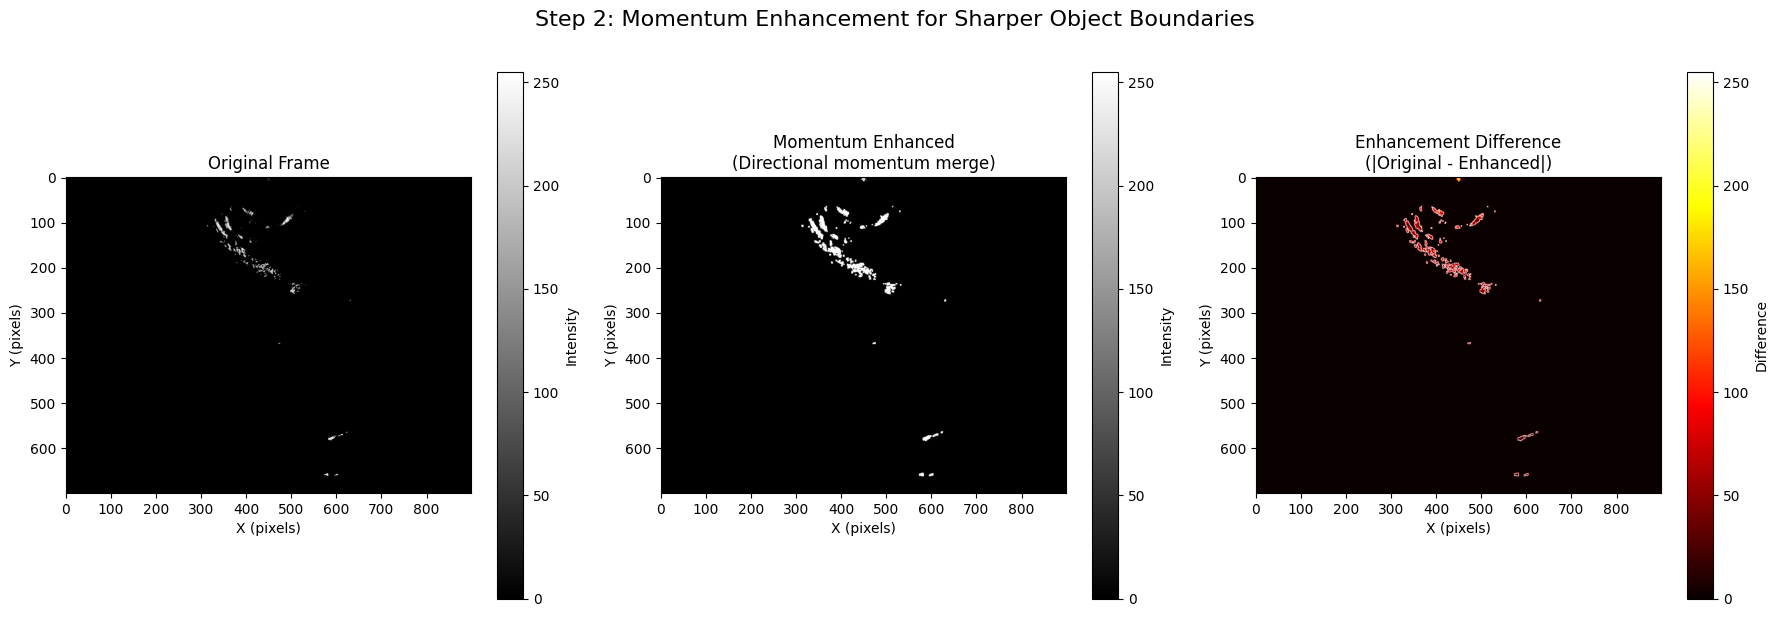

🔧 Momentum Enhancement Configuration:
   • Search radius: 10
   • Momentum threshold: 0.1
   • Momentum decay: 0.9
   • Momentum boost: 10.0

📊 Enhancement Statistics:
   • Mean enhancement: 1.45
   • Max enhancement: 255.00
   • Enhanced pixels: 7181/630000 (1.1%)


In [35]:
# STEP 2: Momentum Enhancement
if 'demo_frame' in locals():
    # Apply momentum enhancement (prepare_input_gray uses directional_momentum_merge)
    momentum_enhanced = prepare_input_gray(demo_frame, IMAGE_PROCESSING_CONFIG)
    
    # Create comparison figure
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Original
    im1 = axes[0].imshow(demo_frame, cmap='gray', aspect='equal')
    axes[0].set_title('Original Frame', fontsize=12)
    axes[0].set_xlabel('X (pixels)')
    axes[0].set_ylabel('Y (pixels)')
    plt.colorbar(im1, ax=axes[0], label='Intensity')
    
    # Enhanced
    im2 = axes[1].imshow(momentum_enhanced, cmap='gray', aspect='equal')
    axes[1].set_title('Momentum Enhanced\n(Directional momentum merge)', fontsize=12)
    axes[1].set_xlabel('X (pixels)')
    axes[1].set_ylabel('Y (pixels)')
    plt.colorbar(im2, ax=axes[1], label='Intensity')
    
    # Difference
    diff = cv2.absdiff(demo_frame, momentum_enhanced)
    im3 = axes[2].imshow(diff, cmap='hot', aspect='equal')
    axes[2].set_title('Enhancement Difference\n(|Original - Enhanced|)', fontsize=12)
    axes[2].set_xlabel('X (pixels)')
    axes[2].set_ylabel('Y (pixels)')
    plt.colorbar(im3, ax=axes[2], label='Difference')
    
    plt.suptitle('Step 2: Momentum Enhancement for Sharper Object Boundaries', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Print configuration and statistics
    print("🔧 Momentum Enhancement Configuration:")
    print(f"   • Search radius: {IMAGE_PROCESSING_CONFIG.get('momentum_search_radius', 3)}")
    print(f"   • Momentum threshold: {IMAGE_PROCESSING_CONFIG.get('momentum_threshold', 0.2)}")
    print(f"   • Momentum decay: {IMAGE_PROCESSING_CONFIG.get('momentum_decay', 0.8)}")
    print(f"   • Momentum boost: {IMAGE_PROCESSING_CONFIG.get('momentum_boost', 1.5)}")
    
    print(f"\n📊 Enhancement Statistics:")
    print(f"   • Mean enhancement: {np.mean(diff):.2f}")
    print(f"   • Max enhancement: {np.max(diff):.2f}")
    print(f"   • Enhanced pixels: {np.count_nonzero(diff)}/{diff.size} ({100*np.count_nonzero(diff)/diff.size:.1f}%)")
    
    # Store for next step
    globals()['momentum_enhanced'] = momentum_enhanced
else:
    print("❌ Demo frame not available. Please run the previous cells first.")

## Step 3: Edge Detection

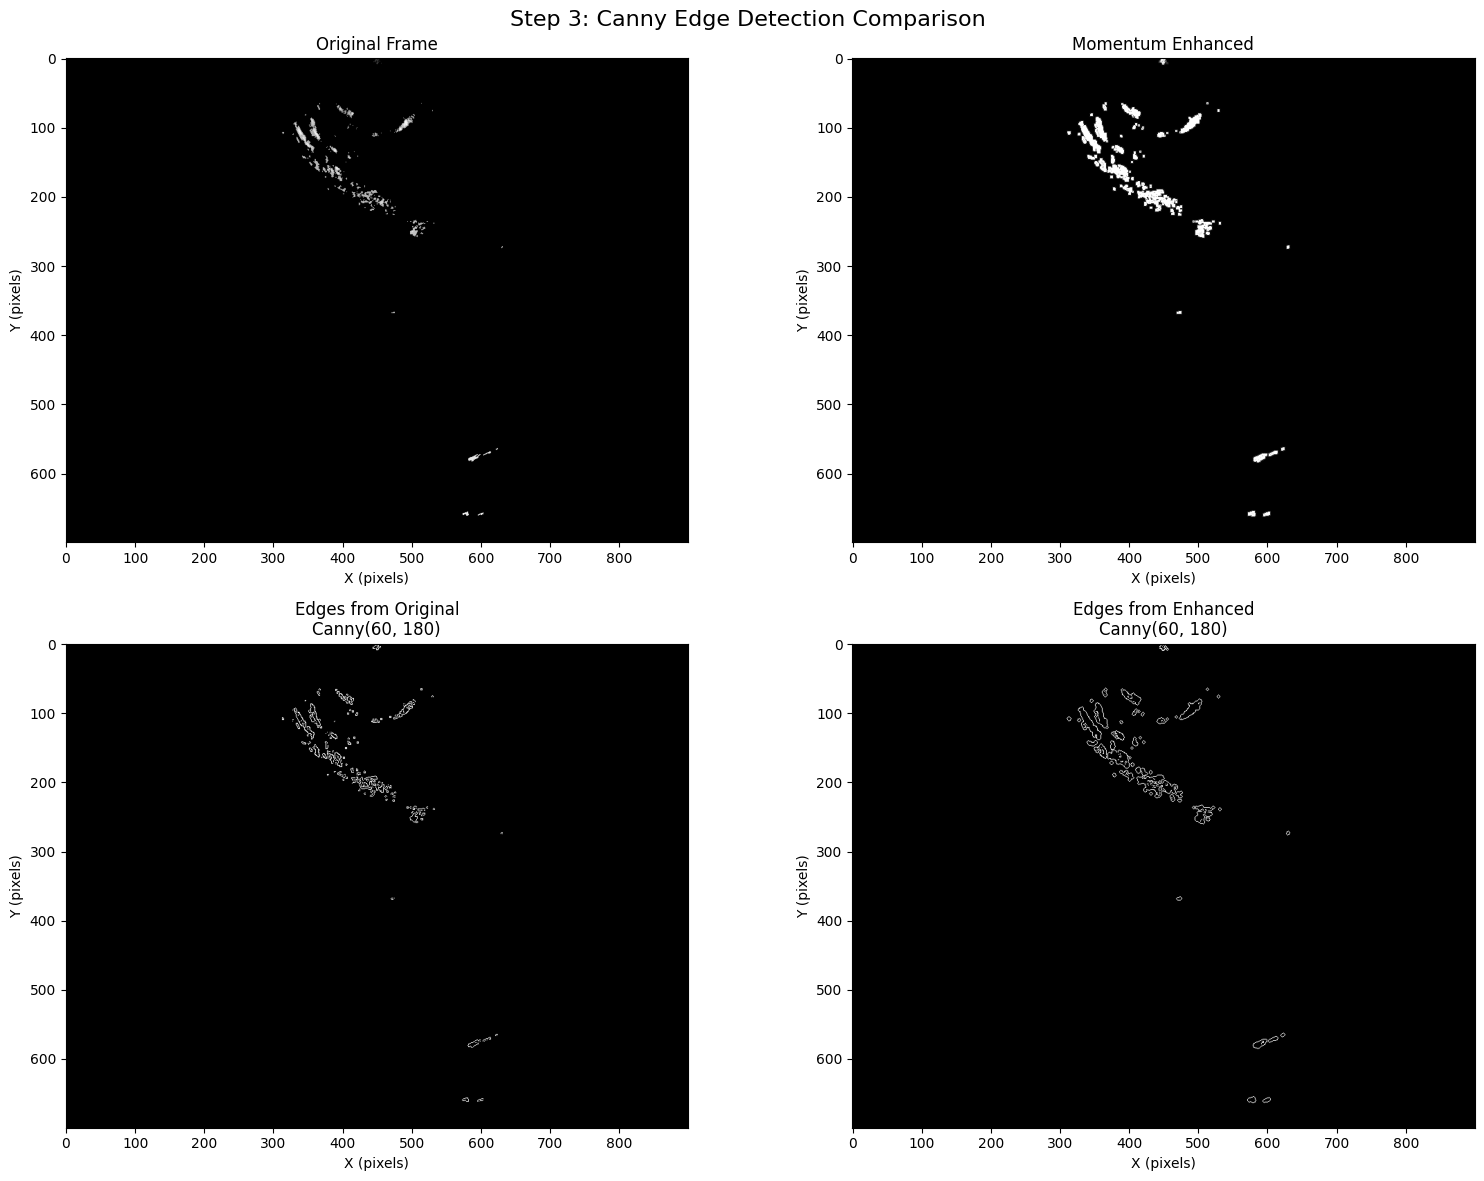

🔧 Canny Edge Detection Configuration:
   • Low threshold: 60
   • High threshold: 180

📊 Edge Detection Statistics:
   • Original edges: 1805/630000 (0.29%)
   • Enhanced edges: 2028/630000 (0.32%)
   • Enhancement improvement: +223 pixels (+0.04%)


In [36]:
# STEP 3: Edge Detection
if 'momentum_enhanced' in locals():
    # Apply Canny edge detection
    low_thresh = IMAGE_PROCESSING_CONFIG.get('canny_low_threshold', 50)
    high_thresh = IMAGE_PROCESSING_CONFIG.get('canny_high_threshold', 150)
    
    # Edges on original vs enhanced
    edges_original = cv2.Canny(demo_frame, low_thresh, high_thresh)
    edges_enhanced = cv2.Canny(momentum_enhanced, low_thresh, high_thresh)
    
    # Create comparison figure
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Original image
    axes[0,0].imshow(demo_frame, cmap='gray', aspect='equal')
    axes[0,0].set_title('Original Frame', fontsize=12)
    axes[0,0].set_xlabel('X (pixels)')
    axes[0,0].set_ylabel('Y (pixels)')
    
    # Enhanced image
    axes[0,1].imshow(momentum_enhanced, cmap='gray', aspect='equal')
    axes[0,1].set_title('Momentum Enhanced', fontsize=12)
    axes[0,1].set_xlabel('X (pixels)')
    axes[0,1].set_ylabel('Y (pixels)')
    
    # Edges from original
    axes[1,0].imshow(edges_original, cmap='gray', aspect='equal')
    axes[1,0].set_title(f'Edges from Original\nCanny({low_thresh}, {high_thresh})', fontsize=12)
    axes[1,0].set_xlabel('X (pixels)')
    axes[1,0].set_ylabel('Y (pixels)')
    
    # Edges from enhanced
    axes[1,1].imshow(edges_enhanced, cmap='gray', aspect='equal')
    axes[1,1].set_title(f'Edges from Enhanced\nCanny({low_thresh}, {high_thresh})', fontsize=12)
    axes[1,1].set_xlabel('X (pixels)')
    axes[1,1].set_ylabel('Y (pixels)')
    
    plt.suptitle('Step 3: Canny Edge Detection Comparison', fontsize=16, y=0.98)
    plt.tight_layout()
    plt.show()
    
    # Edge statistics
    edge_count_orig = np.count_nonzero(edges_original)
    edge_count_enh = np.count_nonzero(edges_enhanced)
    total_pixels = edges_original.size
    
    print("🔧 Canny Edge Detection Configuration:")
    print(f"   • Low threshold: {low_thresh}")
    print(f"   • High threshold: {high_thresh}")
    
    print(f"\n📊 Edge Detection Statistics:")
    print(f"   • Original edges: {edge_count_orig}/{total_pixels} ({100*edge_count_orig/total_pixels:.2f}%)")
    print(f"   • Enhanced edges: {edge_count_enh}/{total_pixels} ({100*edge_count_enh/total_pixels:.2f}%)")
    print(f"   • Enhancement improvement: {edge_count_enh - edge_count_orig:+d} pixels ({100*(edge_count_enh - edge_count_orig)/total_pixels:+.2f}%)")
    
    # Store for next step
    globals()['edges_raw'] = edges_enhanced  # Use enhanced edges for further processing
else:
    print("❌ Momentum enhanced frame not available. Please run the previous cells first.")

## Step 4: Morphological Edge Processing

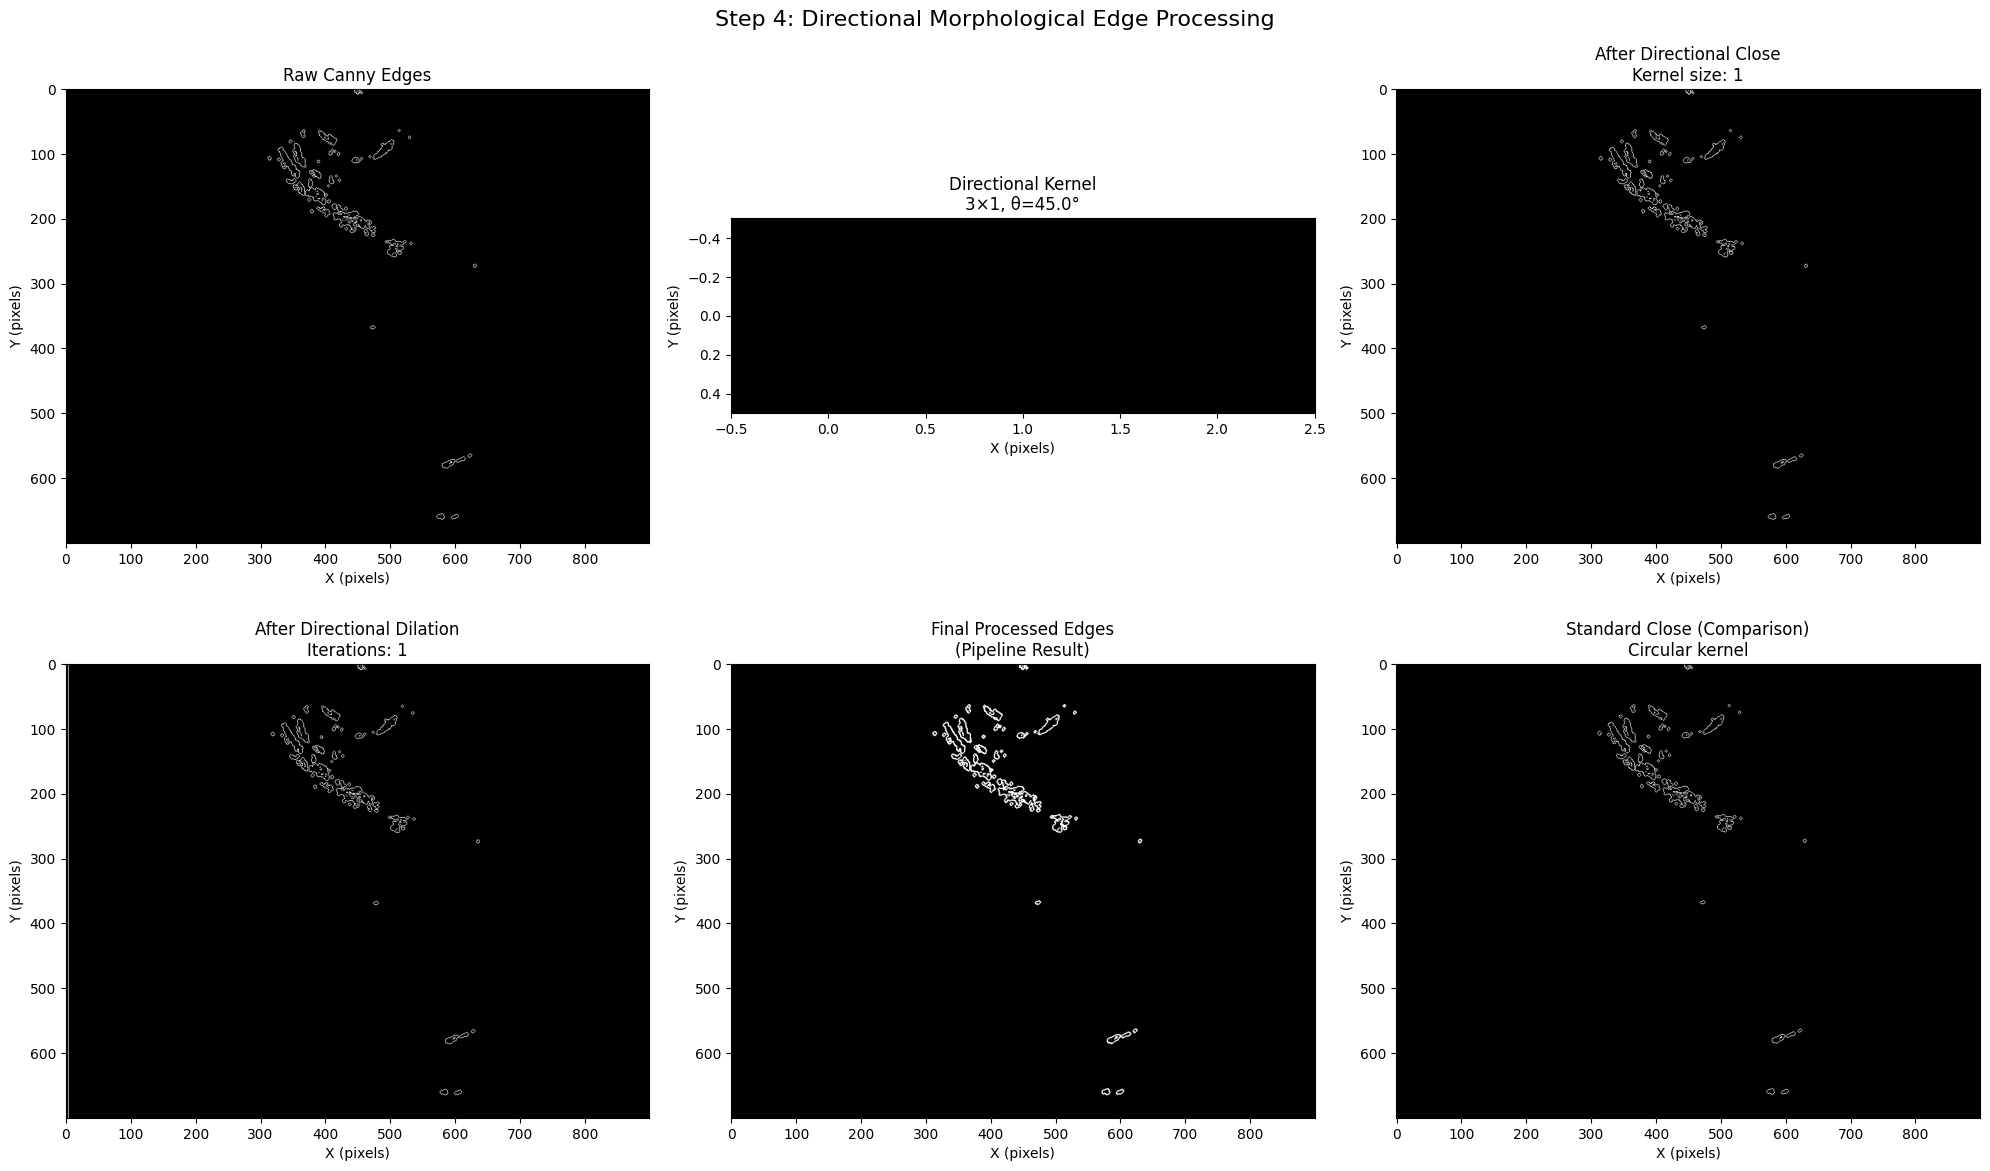

🔧 Directional Morphological Processing Configuration:
   • Morphological close kernel: 1 (ENABLED)
   • Dilation iterations: 1 (ENABLED)
   • Directional morphology: ENABLED
   • Net orientation angle: 45.0°
   • Directional ratio: 3.0:1

📊 Edge Processing Statistics:
   • Raw edges: 2028/630000 (0.32%)
   • After close: 2728/630000 (0.43%)
   • After dilate: 2727/630000 (0.43%)
   • Final processed: 4505/630000 (0.72%)


In [37]:
# STEP 4: Directional Morphological Edge Processing
if 'edges_raw' in locals():
    # Get configuration parameters
    morph_kernel_size = int(IMAGE_PROCESSING_CONFIG.get('morph_close_kernel', 0))
    dilation_iterations = int(IMAGE_PROCESSING_CONFIG.get('edge_dilation_iterations', 0))
    
    # NEW: Directional morphological parameters
    use_directional_morph = True  # Enable directional morphological operations
    net_orientation_angle = 45.0  # Expected net orientation in degrees (can be estimated from AOI)
    directional_ratio = 3.0       # Ratio of major to minor axis (elongation)
    
    # Apply preprocessing to get the full pipeline
    _, edges_processed = preprocess_edges(demo_frame, IMAGE_PROCESSING_CONFIG)
    
    # Show step-by-step morphological operations
    edges_after_close = edges_raw.copy()
    edges_after_dilate = edges_raw.copy()
    
    # Apply morphological close if configured
    if morph_kernel_size > 0:
        if use_directional_morph:
            # Create directional elliptical kernel
            major_axis = int(morph_kernel_size * directional_ratio)
            minor_axis = morph_kernel_size
            
            # Create elliptical kernel
            kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (major_axis, minor_axis))
            
            # Rotate kernel to match net orientation
            kernel_center = (major_axis // 2, minor_axis // 2)
            rotation_matrix = cv2.getRotationMatrix2D(kernel_center, net_orientation_angle, 1.0)
            kernel_close = cv2.warpAffine(kernel_close, rotation_matrix, (major_axis, minor_axis))
            
            # Ensure kernel is odd-sized and properly centered
            if kernel_close.shape[0] % 2 == 0:
                kernel_close = cv2.resize(kernel_close, (kernel_close.shape[1], kernel_close.shape[0] + 1))
            if kernel_close.shape[1] % 2 == 0:
                kernel_close = cv2.resize(kernel_close, (kernel_close.shape[1] + 1, kernel_close.shape[0]))
            
            # Threshold to ensure binary kernel
            kernel_close = (kernel_close > 127).astype(np.uint8)
            
        else:
            # Standard circular kernel
            kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (morph_kernel_size, morph_kernel_size))
            
        edges_after_close = cv2.morphologyEx(edges_raw, cv2.MORPH_CLOSE, kernel_close)
    
    # Apply dilation if configured
    if dilation_iterations > 0:
        if use_directional_morph:
            # Use smaller directional kernel for dilation
            dilate_major = max(3, int(2 * directional_ratio))
            dilate_minor = 2
            kernel_dilate = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (dilate_major, dilate_minor))
            
            # Rotate dilation kernel too
            dilate_center = (dilate_major // 2, dilate_minor // 2)
            rotation_matrix = cv2.getRotationMatrix2D(dilate_center, net_orientation_angle, 1.0)
            kernel_dilate = cv2.warpAffine(kernel_dilate, rotation_matrix, (dilate_major, dilate_minor))
            kernel_dilate = (kernel_dilate > 127).astype(np.uint8)
        else:
            # Standard circular kernel
            kernel_dilate = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
            
        edges_after_dilate = cv2.dilate(edges_after_close, kernel_dilate, iterations=dilation_iterations)
    
    # Create enhanced visualization
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    
    # Raw edges
    axes[0,0].imshow(edges_raw, cmap='gray', aspect='equal')
    axes[0,0].set_title('Raw Canny Edges', fontsize=12)
    axes[0,0].set_xlabel('X (pixels)')
    axes[0,0].set_ylabel('Y (pixels)')
    
    # Show the directional kernel
    if morph_kernel_size > 0 and use_directional_morph and 'kernel_close' in locals():
        axes[0,1].imshow(kernel_close, cmap='gray', aspect='equal')
        axes[0,1].set_title(f'Directional Kernel\n{kernel_close.shape[1]}×{kernel_close.shape[0]}, θ={net_orientation_angle}°', fontsize=12)
        axes[0,1].set_xlabel('X (pixels)')
        axes[0,1].set_ylabel('Y (pixels)')
    else:
        axes[0,1].text(0.5, 0.5, 'Standard\nCircular Kernel', ha='center', va='center', 
                      transform=axes[0,1].transAxes, fontsize=14)
        axes[0,1].set_title('Kernel Visualization', fontsize=12)
        axes[0,1].axis('off')
    
    # After morphological close
    axes[0,2].imshow(edges_after_close, cmap='gray', aspect='equal')
    kernel_type = "Directional" if use_directional_morph else "Standard"
    axes[0,2].set_title(f'After {kernel_type} Close\nKernel size: {morph_kernel_size}' if morph_kernel_size > 0 else 'No Morphological Close\n(kernel size: 0)', fontsize=12)
    axes[0,2].set_xlabel('X (pixels)')
    axes[0,2].set_ylabel('Y (pixels)')
    
    # After dilation
    axes[1,0].imshow(edges_after_dilate, cmap='gray', aspect='equal')
    axes[1,0].set_title(f'After {kernel_type} Dilation\nIterations: {dilation_iterations}' if dilation_iterations > 0 else 'No Dilation\n(iterations: 0)', fontsize=12)
    axes[1,0].set_xlabel('X (pixels)')
    axes[1,0].set_ylabel('Y (pixels)')
    
    # Final processed edges
    axes[1,1].imshow(edges_processed, cmap='gray', aspect='equal')
    axes[1,1].set_title('Final Processed Edges\n(Pipeline Result)', fontsize=12)
    axes[1,1].set_xlabel('X (pixels)')
    axes[1,1].set_ylabel('Y (pixels)')
    
    # Comparison: Standard vs Directional
    if morph_kernel_size > 0 and use_directional_morph:
        # Apply standard morphological close for comparison
        standard_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (morph_kernel_size, morph_kernel_size))
        edges_standard_close = cv2.morphologyEx(edges_raw, cv2.MORPH_CLOSE, standard_kernel)
        
        axes[1,2].imshow(edges_standard_close, cmap='gray', aspect='equal')
        axes[1,2].set_title('Standard Close (Comparison)\nCircular kernel', fontsize=12)
        axes[1,2].set_xlabel('X (pixels)')
        axes[1,2].set_ylabel('Y (pixels)')
    else:
        axes[1,2].text(0.5, 0.5, 'Directional\nMorphology\nDisabled', ha='center', va='center', 
                      transform=axes[1,2].transAxes, fontsize=14)
        axes[1,2].set_title('Comparison (N/A)', fontsize=12)
        axes[1,2].axis('off')
    
    plt.suptitle('Step 4: Directional Morphological Edge Processing', fontsize=16, y=0.98)
    plt.tight_layout()
    plt.show()
    
    # Statistics
    edge_count_raw = np.count_nonzero(edges_raw)
    edge_count_close = np.count_nonzero(edges_after_close)
    edge_count_dilate = np.count_nonzero(edges_after_dilate)
    edge_count_final = np.count_nonzero(edges_processed)
    total_pixels = edges_raw.size
    
    print("🔧 Directional Morphological Processing Configuration:")
    print(f"   • Morphological close kernel: {morph_kernel_size} ({'ENABLED' if morph_kernel_size > 0 else 'DISABLED'})")
    print(f"   • Dilation iterations: {dilation_iterations} ({'ENABLED' if dilation_iterations > 0 else 'DISABLED'})")
    print(f"   • Directional morphology: {'ENABLED' if use_directional_morph else 'DISABLED'}")
    if use_directional_morph:
        print(f"   • Net orientation angle: {net_orientation_angle}°")
        print(f"   • Directional ratio: {directional_ratio:.1f}:1")
    
    print(f"\n📊 Edge Processing Statistics:")
    print(f"   • Raw edges: {edge_count_raw}/{total_pixels} ({100*edge_count_raw/total_pixels:.2f}%)")
    print(f"   • After close: {edge_count_close}/{total_pixels} ({100*edge_count_close/total_pixels:.2f}%)")
    print(f"   • After dilate: {edge_count_dilate}/{total_pixels} ({100*edge_count_dilate/total_pixels:.2f}%)")
    print(f"   • Final processed: {edge_count_final}/{total_pixels} ({100*edge_count_final/total_pixels:.2f}%)")
    
    # Store for next step
    globals()['edges_processed'] = edges_processed
else:
    print("❌ Raw edges not available. Please run the previous cells first.")

## Step 5: Exclusion Masking (Optional)

## Step 6: Contour Detection

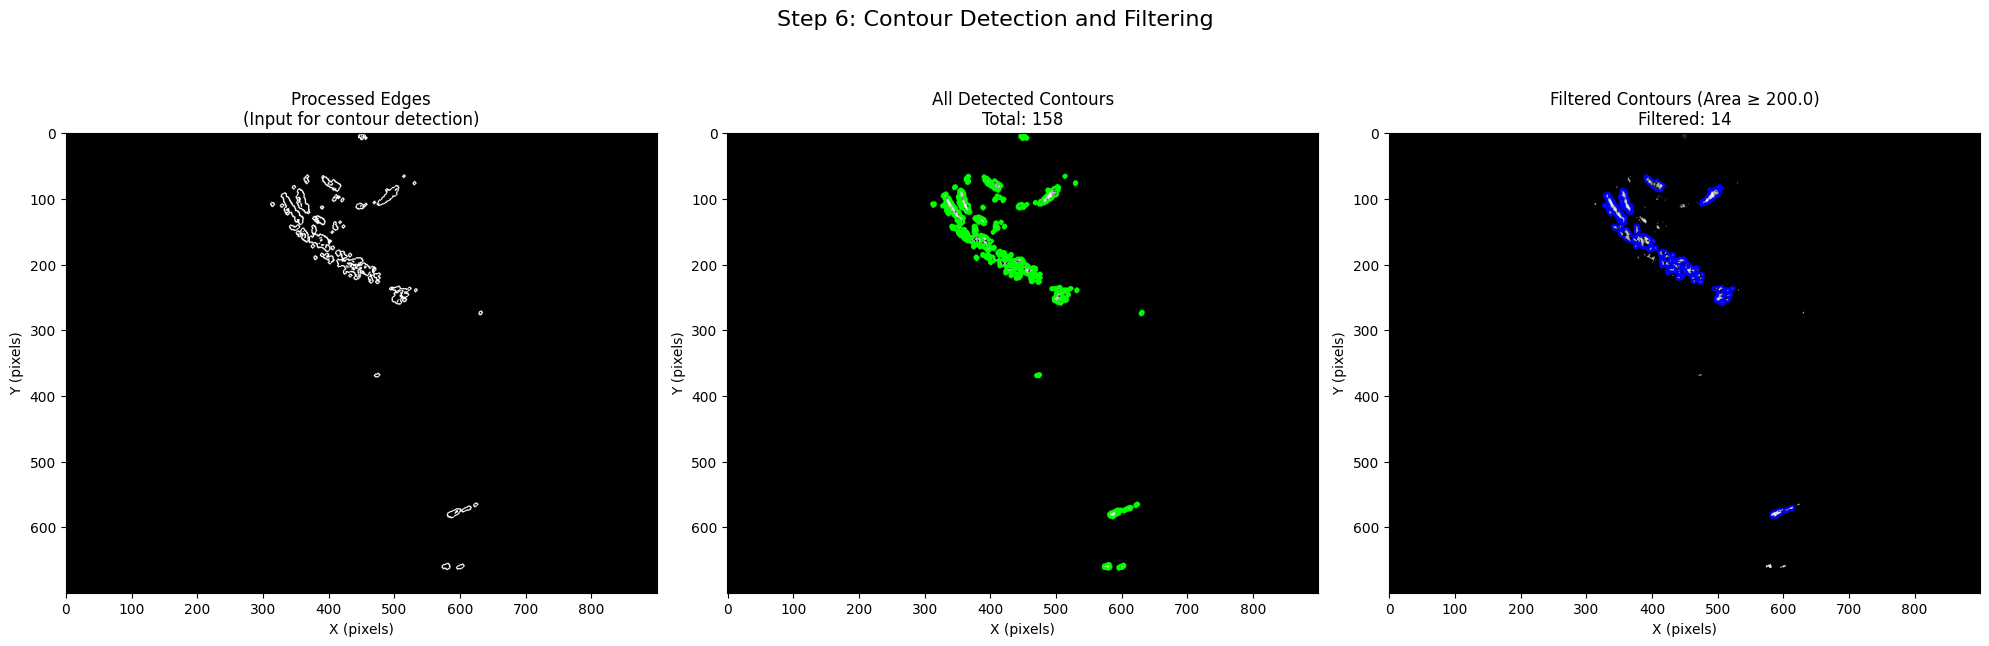

🔧 Contour Detection Configuration:
   • Contour retrieval mode: RETR_LIST
   • Contour approximation: CHAIN_APPROX_SIMPLE
   • Minimum area filter: 200.0

📊 Contour Statistics:
   • Total contours found: 158
   • After area filtering: 14
   • Filtered out: 144
   • Area range (all): 1.5 - 1715.0
   • Mean area (all): 65.3
   • Area range (filtered): 203.0 - 1715.0
   • Mean area (filtered): 532.4

🏆 Top 5 largest contours:
   1. Area: 1715.0, Bounding box: (325, 90) 84×91
   2. Area: 1456.5, Bounding box: (409, 177) 70×53
   3. Area: 544.5, Bounding box: (491, 232) 35×30
   4. Area: 449.0, Bounding box: (349, 84) 23×40
   5. Area: 434.0, Bounding box: (472, 79) 35×32


In [38]:
# STEP 6: Contour Detection
if 'edges_processed' in locals():
    # Find contours
    contours, hierarchy = cv2.findContours(edges_processed, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    
    # Filter by minimum area
    min_area = float(IMAGE_PROCESSING_CONFIG.get('min_contour_area', 100))
    filtered_contours = [c for c in contours if cv2.contourArea(c) >= min_area]
    
    # Create visualization
    fig, axes = plt.subplots(1, 3, figsize=(20, 7))
    
    # Processed edges
    axes[0].imshow(edges_processed, cmap='gray', aspect='equal')
    axes[0].set_title('Processed Edges\n(Input for contour detection)', fontsize=12)
    axes[0].set_xlabel('X (pixels)')
    axes[0].set_ylabel('Y (pixels)')
    
    # All contours
    all_contours_img = cv2.cvtColor(demo_frame, cv2.COLOR_GRAY2BGR)
    if contours:
        cv2.drawContours(all_contours_img, contours, -1, (0, 255, 0), 2)  # Green for all contours
    
    axes[1].imshow(cv2.cvtColor(all_contours_img, cv2.COLOR_BGR2RGB), aspect='equal')
    axes[1].set_title(f'All Detected Contours\nTotal: {len(contours)}', fontsize=12)
    axes[1].set_xlabel('X (pixels)')
    axes[1].set_ylabel('Y (pixels)')
    
    # Filtered contours
    filtered_contours_img = cv2.cvtColor(demo_frame, cv2.COLOR_GRAY2BGR)
    if filtered_contours:
        cv2.drawContours(filtered_contours_img, filtered_contours, -1, (255, 0, 0), 2)  # Red for filtered contours
    
    axes[2].imshow(cv2.cvtColor(filtered_contours_img, cv2.COLOR_BGR2RGB), aspect='equal')
    axes[2].set_title(f'Filtered Contours (Area ≥ {min_area})\nFiltered: {len(filtered_contours)}', fontsize=12)
    axes[2].set_xlabel('X (pixels)')
    axes[2].set_ylabel('Y (pixels)')
    
    plt.suptitle('Step 6: Contour Detection and Filtering', fontsize=16, y=0.98)
    plt.tight_layout()
    plt.show()
    
    # Contour statistics
    if contours:
        areas = [cv2.contourArea(c) for c in contours]
        filtered_areas = [cv2.contourArea(c) for c in filtered_contours]
        
        print("🔧 Contour Detection Configuration:")
        print(f"   • Contour retrieval mode: RETR_LIST")
        print(f"   • Contour approximation: CHAIN_APPROX_SIMPLE")
        print(f"   • Minimum area filter: {min_area}")
        
        print(f"\n📊 Contour Statistics:")
        print(f"   • Total contours found: {len(contours)}")
        print(f"   • After area filtering: {len(filtered_contours)}")
        print(f"   • Filtered out: {len(contours) - len(filtered_contours)}")
        
        if areas:
            print(f"   • Area range (all): {min(areas):.1f} - {max(areas):.1f}")
            print(f"   • Mean area (all): {np.mean(areas):.1f}")
            
        if filtered_areas:
            print(f"   • Area range (filtered): {min(filtered_areas):.1f} - {max(filtered_areas):.1f}")
            print(f"   • Mean area (filtered): {np.mean(filtered_areas):.1f}")
            
        # Show top 5 largest contours
        sorted_contours = sorted(enumerate(filtered_contours), key=lambda x: cv2.contourArea(x[1]), reverse=True)
        print(f"\n🏆 Top {min(5, len(sorted_contours))} largest contours:")
        for i, (orig_idx, contour) in enumerate(sorted_contours[:5]):
            area = cv2.contourArea(contour)
            x, y, w, h = cv2.boundingRect(contour)
            print(f"   {i+1}. Area: {area:.1f}, Bounding box: ({x}, {y}) {w}×{h}")
    else:
        print("❌ No contours found!")
        
    # Store for next step
    globals()['all_contours'] = contours
    globals()['filtered_contours'] = filtered_contours
else:
    print("❌ Processed edges not available. Please run the previous cells first.")

## Step 7: Contour Selection

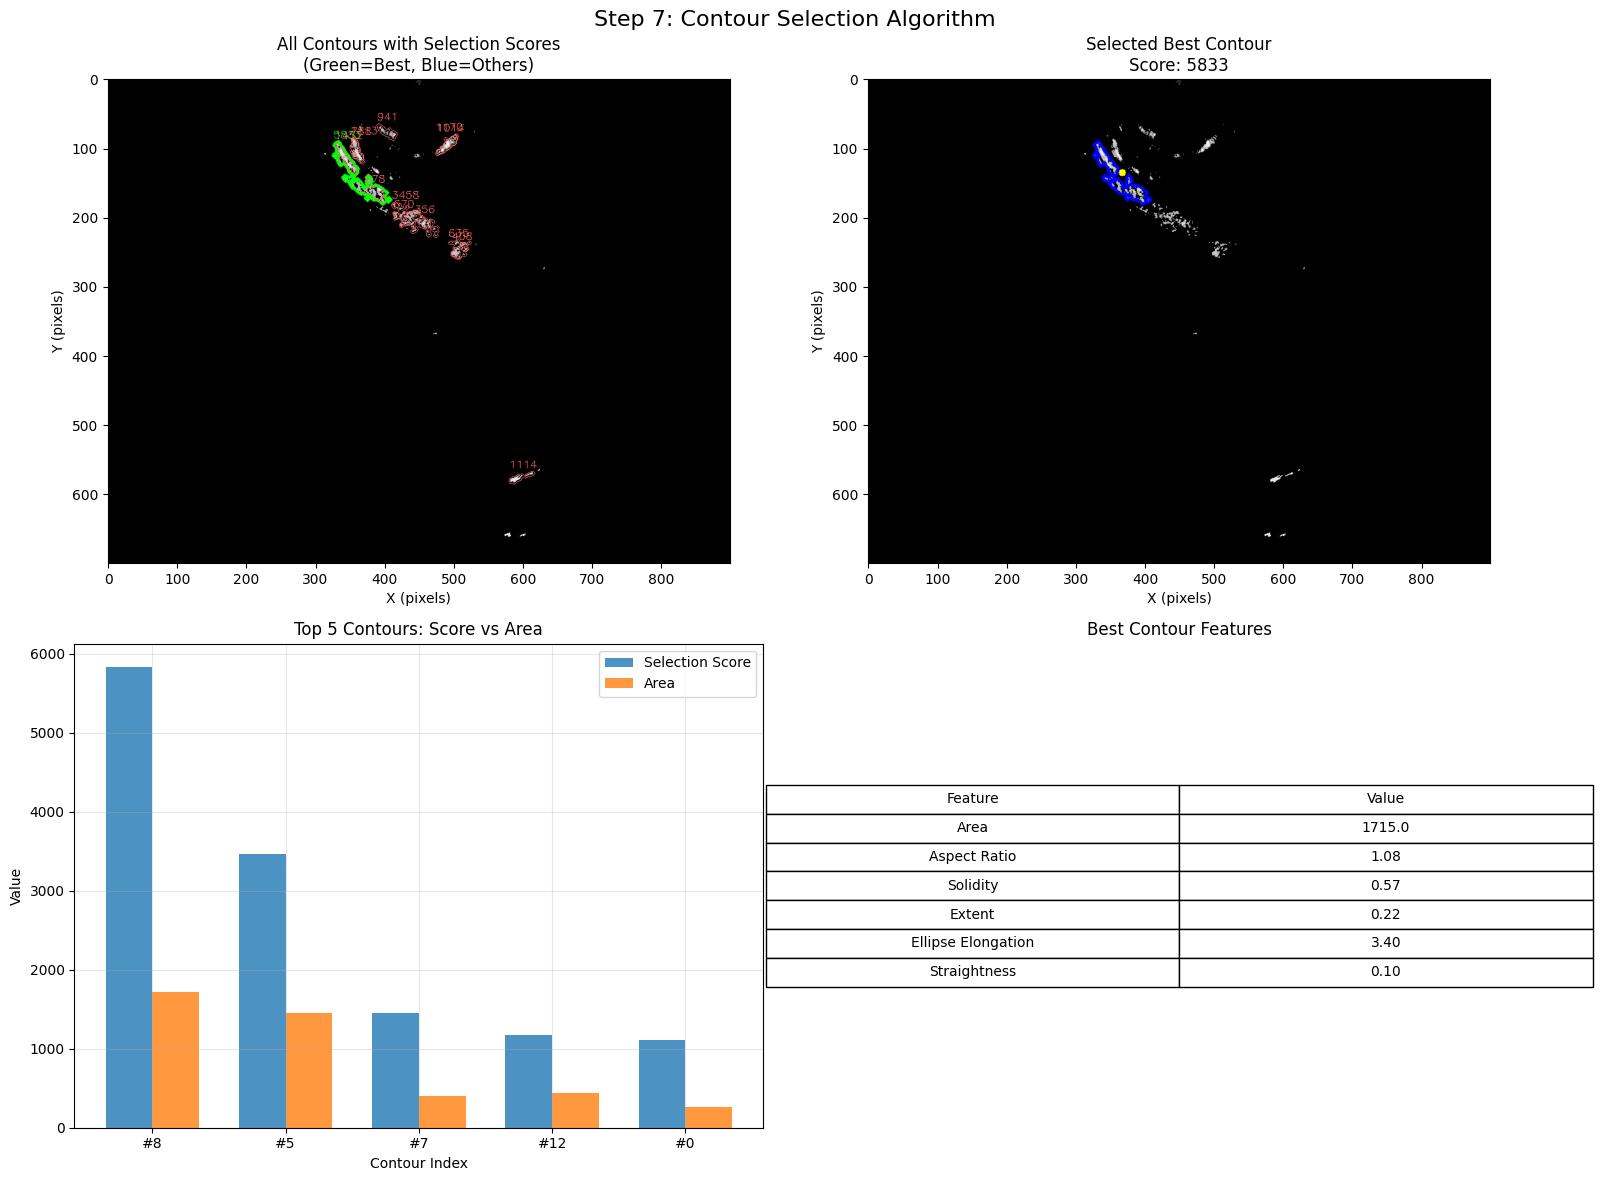

🔧 Contour Selection Configuration:
   • Selection algorithm: Core (area × elongation)
   • Elongation metric: max(aspect_ratio, ellipse_elongation)
   • AOI boost: Not applied (demo mode)
   • Distance penalty: Not applied (no previous position)

📊 Selection Statistics:
   • Candidates evaluated: 14
   • Best score: 5833.3

🏆 Best Contour Details:
   • Area: 1715.0 pixels²
   • Aspect ratio: 1.08
   • Ellipse elongation: 3.40
   • Solidity: 0.57 (convex hull fill)
   • Extent: 0.22 (bounding box fill)
   • Straightness: 0.10 (line fit quality)
   • Centroid: (367.0, 135.5)


In [39]:
# STEP 7: Contour Selection
if 'filtered_contours' in locals() and filtered_contours:
    # Use the core contour selection algorithm
    best_contour, best_features, selection_stats = select_best_contour_core(
        filtered_contours, 
        last_center=None,  # No previous tracking for demo
        aoi=None,          # No AOI for demo
        cfg_img=IMAGE_PROCESSING_CONFIG,
    )
    
    # Compute features for all contours for comparison
    all_contour_features = []
    for i, contour in enumerate(filtered_contours):
        features = compute_contour_features(contour)
        features['contour_index'] = i
        features['area'] = cv2.contourArea(contour)
        
        # Compute the score used by the selection algorithm
        elongation = max(features['aspect_ratio'], features['ellipse_elongation'])
        features['selection_score'] = features['area'] * elongation
        
        all_contour_features.append(features)
    
    # Sort by selection score
    all_contour_features.sort(key=lambda x: x['selection_score'], reverse=True)
    
    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # All filtered contours with scores
    all_scored_img = cv2.cvtColor(demo_frame, cv2.COLOR_GRAY2BGR)
    for i, features in enumerate(all_contour_features):
        contour = filtered_contours[features['contour_index']]
        color = (0, 255, 0) if i == 0 else (100, 100, 255)  # Green for best, light blue for others
        thickness = 3 if i == 0 else 1
        cv2.drawContours(all_scored_img, [contour], -1, color, thickness)
        
        # Add score text
        x, y, w, h = cv2.boundingRect(contour)
        score_text = f"{features['selection_score']:.0f}"
        cv2.putText(all_scored_img, score_text, (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
    
    axes[0,0].imshow(cv2.cvtColor(all_scored_img, cv2.COLOR_BGR2RGB), aspect='equal')
    axes[0,0].set_title('All Contours with Selection Scores\n(Green=Best, Blue=Others)', fontsize=12)
    axes[0,0].set_xlabel('X (pixels)')
    axes[0,0].set_ylabel('Y (pixels)')
    
    # Best contour only
    if best_contour is not None:
        best_contour_img = cv2.cvtColor(demo_frame, cv2.COLOR_GRAY2BGR)
        cv2.drawContours(best_contour_img, [best_contour], -1, (255, 0, 0), 3)  # Red for best
        
        # Add centroid
        if best_features:
            cx, cy = int(best_features['centroid_x']), int(best_features['centroid_y'])
            cv2.circle(best_contour_img, (cx, cy), 5, (0, 255, 255), -1)  # Yellow center
            
        axes[0,1].imshow(cv2.cvtColor(best_contour_img, cv2.COLOR_BGR2RGB), aspect='equal')
        axes[0,1].set_title(f'Selected Best Contour\nScore: {selection_stats.get("best_score", 0):.0f}', fontsize=12)
        axes[0,1].set_xlabel('X (pixels)')
        axes[0,1].set_ylabel('Y (pixels)')
    else:
        axes[0,1].text(0.5, 0.5, 'No Best Contour\nSelected', ha='center', va='center', 
                      transform=axes[0,1].transAxes, fontsize=14)
        axes[0,1].set_title('No Selection Made', fontsize=12)
    
    # Feature comparison bar chart
    if len(all_contour_features) > 0:
        top_5_features = all_contour_features[:5]  # Top 5 by score
        indices = [f"#{f['contour_index']}" for f in top_5_features]
        scores = [f['selection_score'] for f in top_5_features]
        areas = [f['area'] for f in top_5_features]
        
        x = np.arange(len(indices))
        width = 0.35
        
        axes[1,0].bar(x - width/2, scores, width, label='Selection Score', alpha=0.8)
        axes[1,0].bar(x + width/2, areas, width, label='Area', alpha=0.8)
        axes[1,0].set_xlabel('Contour Index')
        axes[1,0].set_ylabel('Value')
        axes[1,0].set_title('Top 5 Contours: Score vs Area')
        axes[1,0].set_xticks(x)
        axes[1,0].set_xticklabels(indices)
        axes[1,0].legend()
        axes[1,0].grid(True, alpha=0.3)
    
    # Feature details table for best contour
    if best_features:
        feature_names = ['Area', 'Aspect Ratio', 'Solidity', 'Extent', 'Ellipse Elongation', 'Straightness']
        feature_values = [
            f"{best_features.get('area', 0):.1f}",
            f"{best_features.get('aspect_ratio', 0):.2f}",
            f"{best_features.get('solidity', 0):.2f}",
            f"{best_features.get('extent', 0):.2f}",
            f"{best_features.get('ellipse_elongation', 0):.2f}",
            f"{best_features.get('straightness', 0):.2f}"
        ]
        
        axes[1,1].axis('tight')
        axes[1,1].axis('off')
        table_data = list(zip(feature_names, feature_values))
        table = axes[1,1].table(cellText=table_data, colLabels=['Feature', 'Value'],
                               cellLoc='center', loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1.2, 1.5)
        axes[1,1].set_title('Best Contour Features', fontsize=12)
    
    plt.suptitle('Step 7: Contour Selection Algorithm', fontsize=16, y=0.98)
    plt.tight_layout()
    plt.show()
    
    # Print detailed statistics
    print("🔧 Contour Selection Configuration:")
    print(f"   • Selection algorithm: Core (area × elongation)")
    print(f"   • Elongation metric: max(aspect_ratio, ellipse_elongation)")
    print(f"   • AOI boost: Not applied (demo mode)")
    print(f"   • Distance penalty: Not applied (no previous position)")
    
    print(f"\n📊 Selection Statistics:")
    print(f"   • Candidates evaluated: {selection_stats.get('total_contours', 0)}")
    print(f"   • Best score: {selection_stats.get('best_score', 0):.1f}")
    
    if best_features:
        print(f"\n🏆 Best Contour Details:")
        print(f"   • Area: {best_features.get('area', 0):.1f} pixels²")
        print(f"   • Aspect ratio: {best_features.get('aspect_ratio', 0):.2f}")
        print(f"   • Ellipse elongation: {best_features.get('ellipse_elongation', 0):.2f}")
        print(f"   • Solidity: {best_features.get('solidity', 0):.2f} (convex hull fill)")
        print(f"   • Extent: {best_features.get('extent', 0):.2f} (bounding box fill)")
        print(f"   • Straightness: {best_features.get('straightness', 0):.2f} (line fit quality)")
        print(f"   • Centroid: ({best_features.get('centroid_x', 0):.1f}, {best_features.get('centroid_y', 0):.1f})")
    
    # Store for next step
    globals()['best_contour'] = best_contour
    globals()['best_features'] = best_features
    
elif 'filtered_contours' in locals():
    print("❌ No filtered contours available for selection!")
else:
    print("❌ Filtered contours not available. Please run the previous cells first.")

## Step 8: Final Distance Measurement

/var/folders/x9/scyyg02s20v0759sw_qxdlqc0000gn/T/ipykernel_40856/1544032284.py:134: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/var/folders/x9/scyyg02s20v0759sw_qxdlqc0000gn/T/ipykernel_40856/1544032284.py:134: UserWarning: Glyph 128207 (\N{STRAIGHT RULER}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/var/folders/x9/scyyg02s20v0759sw_qxdlqc0000gn/T/ipykernel_40856/1544032284.py:134: UserWarning: Glyph 128208 (\N{TRIANGULAR RULER}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/var/folders/x9/scyyg02s20v0759sw_qxdlqc0000gn/T/ipykernel_40856/1544032284.py:134: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/var/folders/x9/scyyg02s20v0759sw_qxdlqc0000gn/T/ipykernel_40856/1544032284.py:134: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/var/folders/x9/scyyg02s20v075

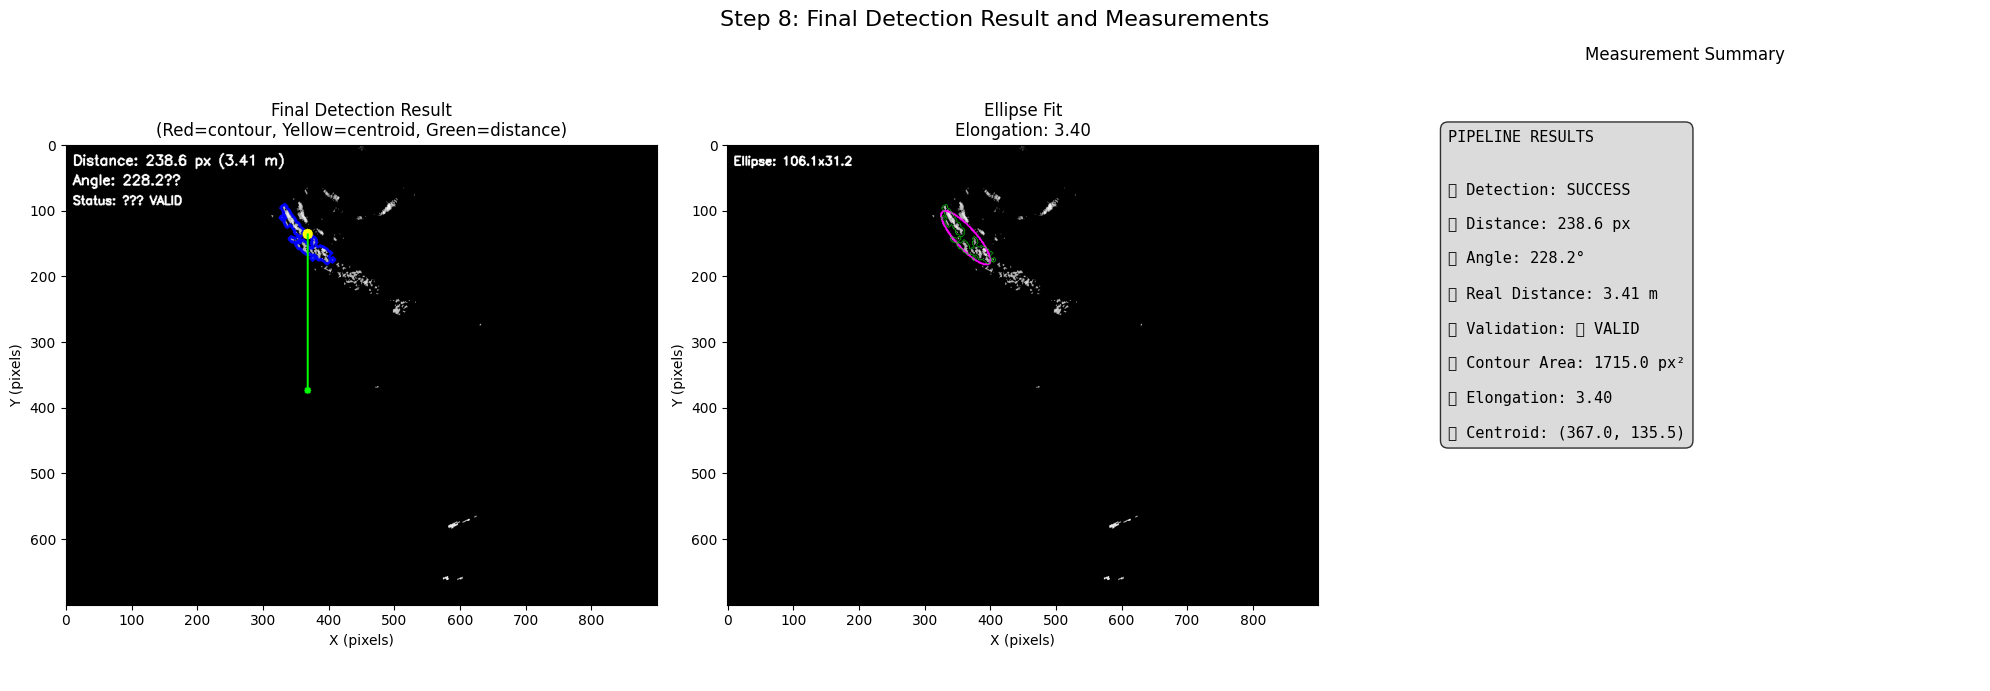

🎯 NET DETECTION PIPELINE COMPLETE!
✅ Detection Status: SUCCESS
📏 Distance: 238.6 pixels
🌍 Real Distance: 3.41 meters
📐 Angle: 228.2 degrees
🔍 Validation: ✅ VALID
📊 Processing Config: VALIDATION ON


In [40]:
# STEP 8: Final Distance Measurement and Tracking
if 'best_contour' in locals() and best_contour is not None and 'best_features' in locals():
    # Calculate distance and angle using the utility function
    
    H, W = demo_frame.shape
    distance_pixels, angle_degrees = _distance_angle_from_contour(best_contour, W, H)
    
    # Apply distance validation if configured
    if IMAGE_PROCESSING_CONFIG.get('use_distance_validation', True):
        # For demo, we don't have previous state, so just validate bounds
        if distance_pixels is not None:
            if 0 <= distance_pixels <= H:
                validated_distance = distance_pixels
                validation_status = "✅ VALID"
            else:
                validated_distance = None
                validation_status = f"❌ INVALID (out of bounds: {distance_pixels:.1f})"
        else:
            validated_distance = None
            validation_status = "❌ INVALID (no distance detected)"
    else:
        validated_distance = distance_pixels
        validation_status = "⚠️ NOT VALIDATED (validation disabled)"
    
    # Convert to meters using the extent if available
    distance_meters = None
    if validated_distance is not None and 'extent' in locals():
        x_min, x_max, y_min, y_max = extent
        height_m = y_max - y_min
        px2m_y = height_m / H
        distance_meters = y_min + validated_distance * px2m_y
    
    # Create final visualization
    fig, axes = plt.subplots(1, 3, figsize=(20, 7))
    
    # Final result overlay
    result_img = cv2.cvtColor(demo_frame, cv2.COLOR_GRAY2BGR)
    
    # Draw the best contour
    cv2.drawContours(result_img, [best_contour], -1, (255, 0, 0), 3)  # Red contour
    
    # Draw centroid
    if best_features:
        cx, cy = int(best_features['centroid_x']), int(best_features['centroid_y'])
        cv2.circle(result_img, (cx, cy), 8, (0, 255, 255), -1)  # Yellow center
        
        # Draw distance line to bottom of image
        if validated_distance is not None:
            distance_y = int(cy + validated_distance)
            cv2.line(result_img, (cx, cy), (cx, distance_y), (0, 255, 0), 2)  # Green distance line
            cv2.circle(result_img, (cx, distance_y), 5, (0, 255, 0), -1)  # Green end point
    
    # Add text overlay with measurements
    if validated_distance is not None:
        dist_text = f"Distance: {validated_distance:.1f} px"
        if distance_meters is not None:
            dist_text += f" ({distance_meters:.2f} m)"
        cv2.putText(result_img, dist_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        
    if angle_degrees is not None:
        angle_text = f"Angle: {angle_degrees:.1f}°"
        cv2.putText(result_img, angle_text, (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
    
    status_text = f"Status: {validation_status}"
    cv2.putText(result_img, status_text, (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
    
    axes[0].imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB), aspect='equal')
    axes[0].set_title('Final Detection Result\n(Red=contour, Yellow=centroid, Green=distance)', fontsize=12)
    axes[0].set_xlabel('X (pixels)')
    axes[0].set_ylabel('Y (pixels)')
    
    # Ellipse fitting if possible
    ellipse_img = cv2.cvtColor(demo_frame, cv2.COLOR_GRAY2BGR)
    if len(best_contour) >= 5:
        try:
            ellipse = cv2.fitEllipse(best_contour)
            cv2.ellipse(ellipse_img, ellipse, (255, 0, 255), 2)  # Magenta ellipse
            cv2.drawContours(ellipse_img, [best_contour], -1, (0, 255, 0), 1)  # Green contour for comparison
            
            # Ellipse info
            (cx, cy), (minor_axis, major_axis), angle = ellipse
            ellipse_elongation = major_axis / minor_axis if minor_axis > 0 else 0
            
            ellipse_text = f"Ellipse: {major_axis:.1f}x{minor_axis:.1f}"
            cv2.putText(ellipse_img, ellipse_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
            
            axes[1].imshow(cv2.cvtColor(ellipse_img, cv2.COLOR_BGR2RGB), aspect='equal')
            axes[1].set_title(f'Ellipse Fit\nElongation: {ellipse_elongation:.2f}', fontsize=12)
        except:
            axes[1].text(0.5, 0.5, 'Ellipse Fitting\nFailed', ha='center', va='center', 
                        transform=axes[1].transAxes, fontsize=14)
            axes[1].set_title('Ellipse Fit (Failed)', fontsize=12)
    else:
        axes[1].text(0.5, 0.5, 'Too Few Points\nfor Ellipse', ha='center', va='center', 
                    transform=axes[1].transAxes, fontsize=14)
        axes[1].set_title('Ellipse Fit (N/A)', fontsize=12)
    
    axes[1].set_xlabel('X (pixels)')
    axes[1].set_ylabel('Y (pixels)')
    
    # Results summary
    axes[2].axis('off')
    
    # Build summary text step by step to avoid f-string complexity
    summary_lines = [
        "PIPELINE RESULTS",
        "",
        "",
        f"🎯 Detection: {'SUCCESS' if best_contour is not None else 'FAILED'}",
        "",
        f"📏 Distance: {validated_distance:.1f} px" if validated_distance else "📏 Distance: N/A",
        "",
        f"📐 Angle: {angle_degrees:.1f}°" if angle_degrees else "📐 Angle: N/A",
        "",
        f"🌍 Real Distance: {distance_meters:.2f} m" if distance_meters else "🌍 Real Distance: N/A",
        "",
        f"✅ Validation: {validation_status}",
        "",
        f"📊 Contour Area: {best_features.get('area', 0):.1f} px²",
        "",
        f"🔄 Elongation: {max(best_features.get('aspect_ratio', 0), best_features.get('ellipse_elongation', 0)):.2f}",
        "",
        f"📍 Centroid: ({best_features.get('centroid_x', 0):.1f}, {best_features.get('centroid_y', 0):.1f})"
    ]
    
    summary_text = "\n".join(summary_lines)
    
    axes[2].text(0.1, 0.9, summary_text, transform=axes[2].transAxes, fontsize=11, 
                verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8))
    axes[2].set_title('Measurement Summary', fontsize=12)
    
    plt.suptitle('Step 8: Final Detection Result and Measurements', fontsize=16, y=0.98)
    plt.tight_layout()
    plt.show()
    
    # Print final summary
    print("🎯 NET DETECTION PIPELINE COMPLETE!")
    print("="*50)
    print(f"✅ Detection Status: {'SUCCESS' if best_contour is not None else 'FAILED'}")
    if validated_distance is not None:
        print(f"📏 Distance: {validated_distance:.1f} pixels")
        if distance_meters is not None:
            print(f"🌍 Real Distance: {distance_meters:.2f} meters")
    if angle_degrees is not None:
        print(f"📐 Angle: {angle_degrees:.1f} degrees")
    print(f"🔍 Validation: {validation_status}")
    validation_config = 'VALIDATION ON' if IMAGE_PROCESSING_CONFIG.get('use_distance_validation', True) else 'VALIDATION OFF'
    print(f"📊 Processing Config: {validation_config}")
    
else:
    print("❌ No best contour available for final measurement.")
    print("💡 This could mean no suitable net candidate was found in the image.")
    
    # Show what we have
    if 'demo_frame' in locals():
        plt.figure(figsize=(10, 8))
        plt.imshow(demo_frame, cmap='gray')
        plt.title('No Detection Result\nNo suitable net contour found', fontsize=14)
        plt.colorbar(label='Intensity')
        plt.xlabel('X (pixels)')
        plt.ylabel('Y (pixels)')
        plt.tight_layout()
        plt.show()
        
        print("\n🔧 Troubleshooting suggestions:")
        print("   • Try adjusting IMAGE_PROCESSING_CONFIG parameters")
        print("   • Check if the frame contains visible net structures")
        print("   • Lower min_contour_area threshold")
        print("   • Adjust Canny edge detection thresholds")

🧪 TESTING DIFFERENT MERGING APPROACHES
📊 Starting point:
   • Original non-zero pixels: 2,275
   • Momentum enhanced: 7,223 (+4,948)

🔄 Test 1: ITERATIVE MOMENTUM (2 passes)
   Pass 1: 12,020 pixels (+4,797)
   Pass 2: 16,072 pixels (+8,849)

🔧 Test 2: MORPHOLOGICAL CLOSING (different sizes and shapes)
   🔵 ELLIPTICAL KERNELS:
   Ellipse 3x3: 7,451 pixels (+228)
   Ellipse 5x5: 7,887 pixels (+664)
   Ellipse 7x7: 8,255 pixels (+1,032)
   Ellipse 9x9: 8,476 pixels (+1,253)
   Ellipse 11x11: 8,895 pixels (+1,672)
   ✚ CROSS KERNELS:
   Cross 3x3: 7,451 pixels (+228)
   Cross 5x5: 7,769 pixels (+546)
   Cross 7x7: 8,013 pixels (+790)
   Cross 9x9: 8,235 pixels (+1,012)
   Cross 11x11: 8,392 pixels (+1,169)
   ▭ RECTANGULAR KERNELS:
   Rect 3x3: 7,793 pixels (+570)
   Rect 5x5: 8,104 pixels (+881)
   Rect 7x7: 8,402 pixels (+1,179)
   Rect 9x9: 8,744 pixels (+1,521)
   Rect 11x11: 9,120 pixels (+1,897)

🎯 Test 3: DIRECTIONAL MORPHOLOGICAL CLOSING
   Angle   0°: 10,589 pixels (+3,366)
   An

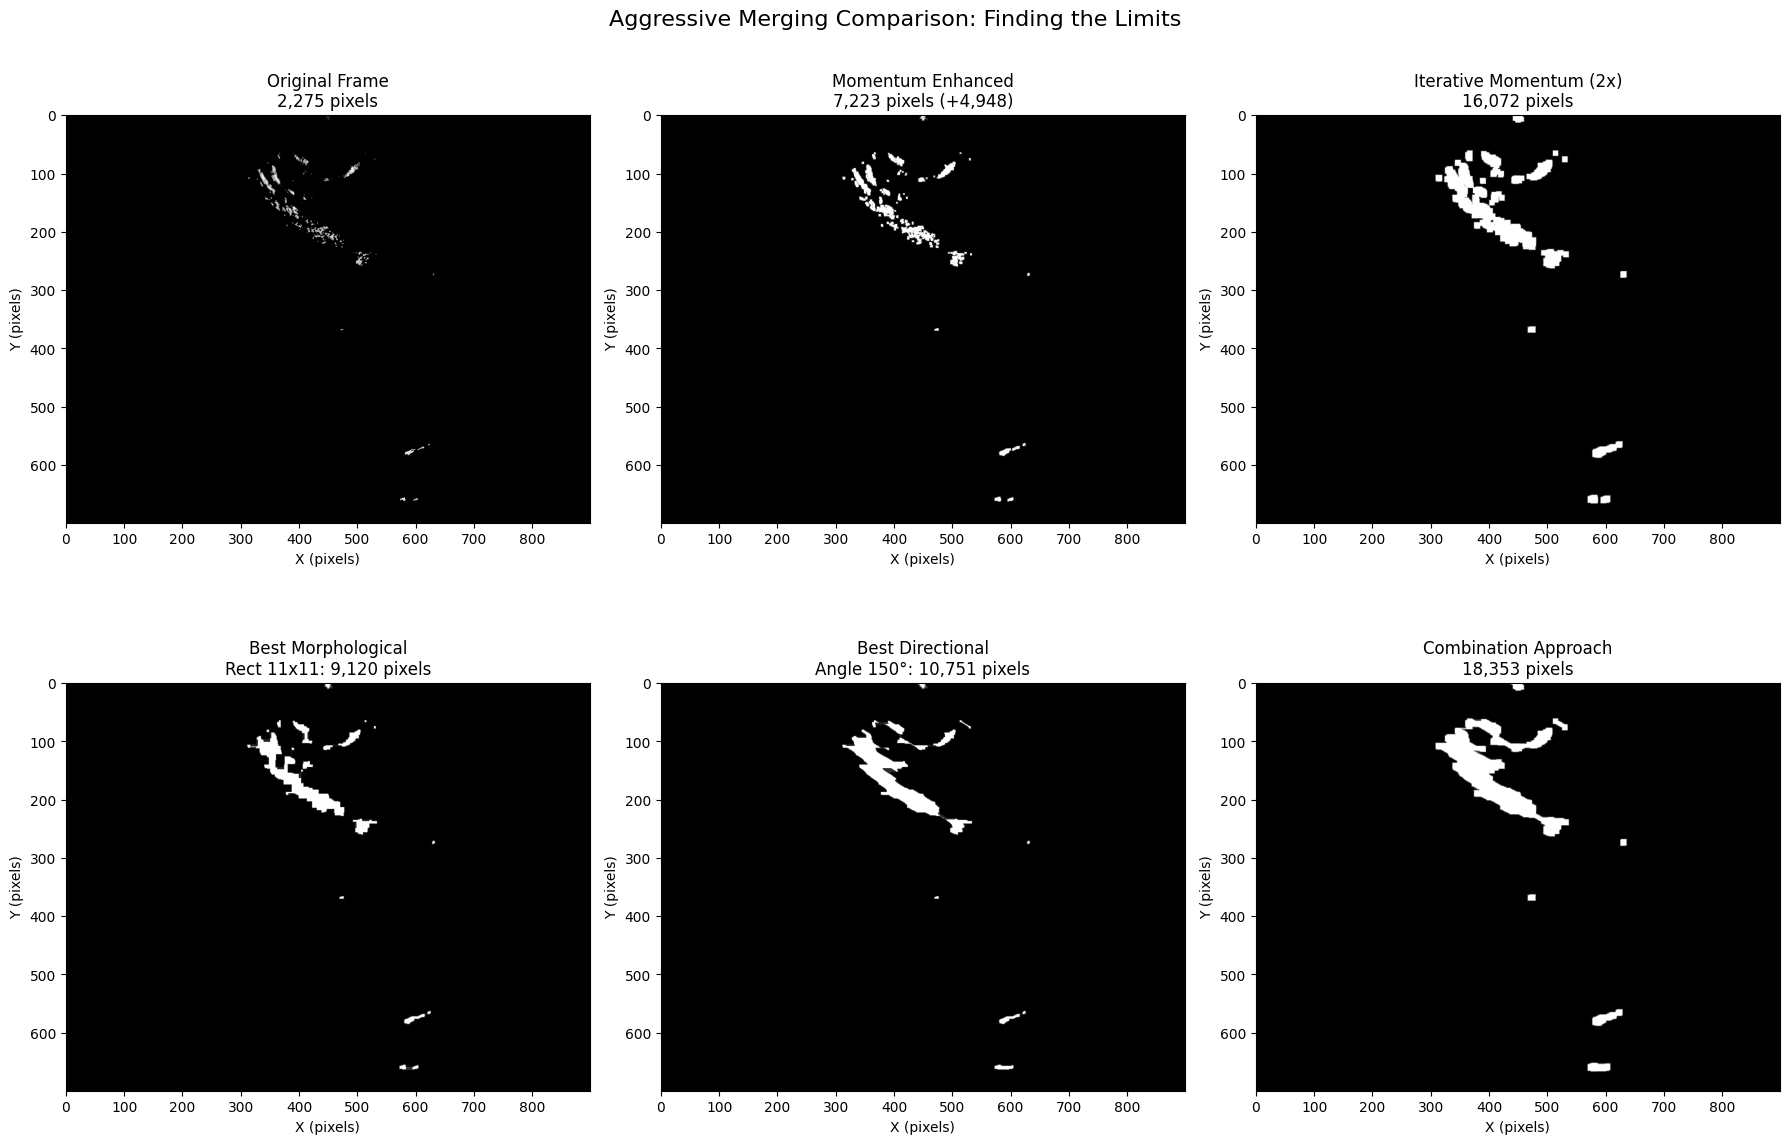


📊 SUMMARY - Pixel gain over momentum enhanced:
   • Iterative momentum: +8,849
   • Best morphological: +1,897
   • Best directional: +3,528
   • Combination: +11,130

✅ Best aggressive merging result stored in 'aggressive_merged'


In [43]:
# 🧪 EXPERIMENTAL: Testing Aggressive Merging Approaches
# =====================================================

if 'momentum_enhanced' in locals():
    import cv2
    import numpy as np
    
    print("🧪 TESTING DIFFERENT MERGING APPROACHES")
    print("=" * 50)
    
    # Get original for comparison
    original_nonzero = np.count_nonzero(demo_frame)
    momentum_nonzero = np.count_nonzero(momentum_enhanced)
    
    print(f"📊 Starting point:")
    print(f"   • Original non-zero pixels: {original_nonzero:,}")
    print(f"   • Momentum enhanced: {momentum_nonzero:,} (+{momentum_nonzero - original_nonzero:,})")
    
    # Test 1: Iterative momentum enhancement
    print(f"\n🔄 Test 1: ITERATIVE MOMENTUM (2 passes)")
    iterative_enhanced = momentum_enhanced.copy()
    for i in range(2):
        from utils.sonar_image_analysis import prepare_input_gray
        iterative_enhanced = prepare_input_gray(iterative_enhanced, IMAGE_PROCESSING_CONFIG)
        iter_nonzero = np.count_nonzero(iterative_enhanced)
        print(f"   Pass {i+1}: {iter_nonzero:,} pixels (+{iter_nonzero - momentum_nonzero:,})")
    
    # Test 2: Morphological approach with different kernel sizes and shapes
    print(f"\n🔧 Test 2: MORPHOLOGICAL CLOSING (different sizes and shapes)")
    morph_results = {}
    
    # Test elliptical kernels
    print(f"   🔵 ELLIPTICAL KERNELS:")
    for size in [3, 5, 7, 9, 11]:
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (size, size))
        closed = cv2.morphologyEx(momentum_enhanced, cv2.MORPH_CLOSE, kernel)
        closed_nonzero = np.count_nonzero(closed)
        morph_results[f'ellipse_{size}'] = closed_nonzero
        print(f"   Ellipse {size}x{size}: {closed_nonzero:,} pixels (+{closed_nonzero - momentum_nonzero:,})")
    
    # Test cross-shaped kernels
    print(f"   ✚ CROSS KERNELS:")
    for size in [3, 5, 7, 9, 11]:
        kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (size, size))
        closed = cv2.morphologyEx(momentum_enhanced, cv2.MORPH_CLOSE, kernel)
        closed_nonzero = np.count_nonzero(closed)
        morph_results[f'cross_{size}'] = closed_nonzero
        print(f"   Cross {size}x{size}: {closed_nonzero:,} pixels (+{closed_nonzero - momentum_nonzero:,})")
    
    # Test rectangular kernels for comparison
    print(f"   ▭ RECTANGULAR KERNELS:")
    for size in [3, 5, 7, 9, 11]:
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (size, size))
        closed = cv2.morphologyEx(momentum_enhanced, cv2.MORPH_CLOSE, kernel)
        closed_nonzero = np.count_nonzero(closed)
        morph_results[f'rect_{size}'] = closed_nonzero
        print(f"   Rect {size}x{size}: {closed_nonzero:,} pixels (+{closed_nonzero - momentum_nonzero:,})")
    
    # Test 3: Directional morphological closing
    print(f"\n🎯 Test 3: DIRECTIONAL MORPHOLOGICAL CLOSING")
    # Create elongated kernels in different orientations
    orientations = [0, 30, 60, 90, 120, 150]  # degrees
    directional_results = {}
    
    for angle in orientations:
        # Create elongated kernel rotated to angle
        kernel_size = 11
        aspect_ratio = 3  # Make it 3x more elongated
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size * aspect_ratio, kernel_size))
        
        # Rotate the kernel
        M = cv2.getRotationMatrix2D((kernel_size * aspect_ratio // 2, kernel_size // 2), angle, 1.0)
        rotated_kernel = cv2.warpAffine(kernel.astype(np.float32), M, (kernel_size * aspect_ratio, kernel_size))
        rotated_kernel = (rotated_kernel > 0.5).astype(np.uint8)
        
        # Apply morphological closing
        directional_closed = cv2.morphologyEx(momentum_enhanced, cv2.MORPH_CLOSE, rotated_kernel)
        dir_nonzero = np.count_nonzero(directional_closed)
        directional_results[angle] = dir_nonzero
        print(f"   Angle {angle:3d}°: {dir_nonzero:,} pixels (+{dir_nonzero - momentum_nonzero:,})")
    
    # Test 4: Combination approach
    print(f"\n🎯 Test 4: COMBINATION APPROACH")
    
    # Find best directional angle
    best_angle = max(directional_results, key=directional_results.get)
    print(f"   Best directional angle: {best_angle}°")
    
    # Create optimized kernel
    kernel_size = 7
    aspect_ratio = 4
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size * aspect_ratio, kernel_size))
    M = cv2.getRotationMatrix2D((kernel_size * aspect_ratio // 2, kernel_size // 2), best_angle, 1.0)
    optimal_kernel = cv2.warpAffine(kernel.astype(np.float32), M, (kernel_size * aspect_ratio, kernel_size))
    optimal_kernel = (optimal_kernel > 0.5).astype(np.uint8)
    
    # Apply iterative directional closing
    combination_result = iterative_enhanced.copy()
    for i in range(2):
        combination_result = cv2.morphologyEx(combination_result, cv2.MORPH_CLOSE, optimal_kernel)
        combo_nonzero = np.count_nonzero(combination_result)
        print(f"   Combo pass {i+1}: {combo_nonzero:,} pixels")
    
    # Visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Original and momentum
    axes[0,0].imshow(demo_frame, cmap='gray', aspect='equal')
    axes[0,0].set_title(f'Original Frame\n{original_nonzero:,} pixels', fontsize=12)
    
    axes[0,1].imshow(momentum_enhanced, cmap='gray', aspect='equal')
    axes[0,1].set_title(f'Momentum Enhanced\n{momentum_nonzero:,} pixels (+{momentum_nonzero - original_nonzero:,})', fontsize=12)
    
    # Iterative momentum
    axes[0,2].imshow(iterative_enhanced, cmap='gray', aspect='equal')
    axes[0,2].set_title(f'Iterative Momentum (2x)\n{np.count_nonzero(iterative_enhanced):,} pixels', fontsize=12)
    
    # Best morphological - find best performing kernel
    best_morph_key = max(morph_results, key=morph_results.get)
    best_morph_type, best_morph_size = best_morph_key.split('_')
    best_morph_size = int(best_morph_size)
    
    # Create the best kernel based on type
    if best_morph_type == 'ellipse':
        best_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (best_morph_size, best_morph_size))
        kernel_name = f"Ellipse {best_morph_size}x{best_morph_size}"
    elif best_morph_type == 'cross':
        best_kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (best_morph_size, best_morph_size))
        kernel_name = f"Cross {best_morph_size}x{best_morph_size}"
    elif best_morph_type == 'rect':
        best_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (best_morph_size, best_morph_size))
        kernel_name = f"Rect {best_morph_size}x{best_morph_size}"
    
    best_morph = cv2.morphologyEx(momentum_enhanced, cv2.MORPH_CLOSE, best_kernel)
    
    axes[1,0].imshow(best_morph, cmap='gray', aspect='equal')
    axes[1,0].set_title(f'Best Morphological\n{kernel_name}: {np.count_nonzero(best_morph):,} pixels', fontsize=12)
    
    # Best directional
    best_dir_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11 * 3, 11))
    M = cv2.getRotationMatrix2D((11 * 3 // 2, 11 // 2), best_angle, 1.0)
    best_dir_kernel = cv2.warpAffine(best_dir_kernel.astype(np.float32), M, (11 * 3, 11))
    best_dir_kernel = (best_dir_kernel > 0.5).astype(np.uint8)
    best_directional = cv2.morphologyEx(momentum_enhanced, cv2.MORPH_CLOSE, best_dir_kernel)
    
    axes[1,1].imshow(best_directional, cmap='gray', aspect='equal')
    axes[1,1].set_title(f'Best Directional\nAngle {best_angle}°: {np.count_nonzero(best_directional):,} pixels', fontsize=12)
    
    # Combination result
    axes[1,2].imshow(combination_result, cmap='gray', aspect='equal')
    axes[1,2].set_title(f'Combination Approach\n{np.count_nonzero(combination_result):,} pixels', fontsize=12)
    
    for ax in axes.flat:
        ax.set_xlabel('X (pixels)')
        ax.set_ylabel('Y (pixels)')
    
    plt.suptitle('Aggressive Merging Comparison: Finding the Limits', fontsize=16, y=0.98)
    plt.tight_layout()
    plt.show()
    
    print(f"\n📊 SUMMARY - Pixel gain over momentum enhanced:")
    print(f"   • Iterative momentum: +{np.count_nonzero(iterative_enhanced) - momentum_nonzero:,}")
    print(f"   • Best morphological: +{np.count_nonzero(best_morph) - momentum_nonzero:,}")
    print(f"   • Best directional: +{np.count_nonzero(best_directional) - momentum_nonzero:,}")
    print(f"   • Combination: +{np.count_nonzero(combination_result) - momentum_nonzero:,}")
    
    # Store the best result for further use
    globals()['aggressive_merged'] = combination_result
    print(f"\n✅ Best aggressive merging result stored in 'aggressive_merged'")
    
else:
    print("❌ Momentum enhanced frame not available. Run previous cells first.")

🔧 PIPELINE ENHANCEMENT SELECTOR
📊 Selected enhancement mode: best_morph


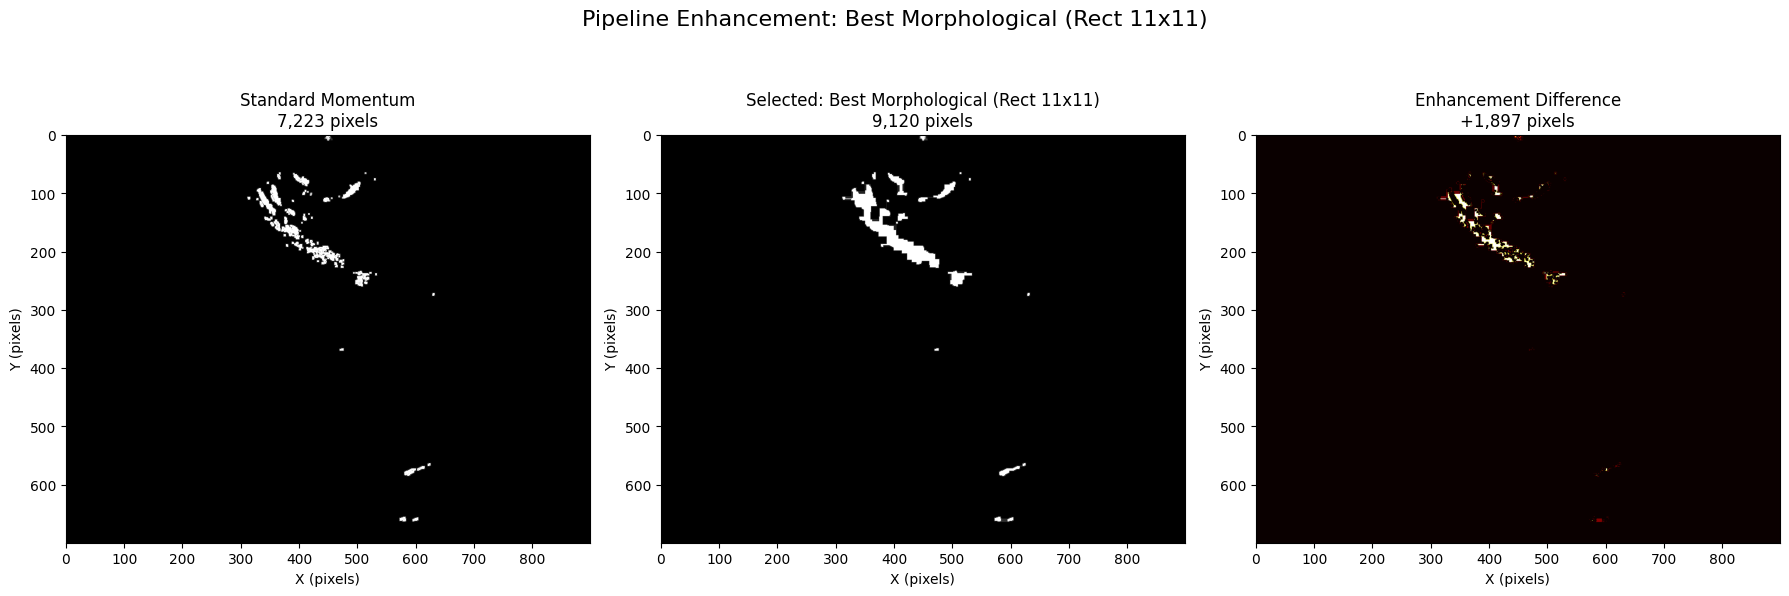


✅ Enhancement applied: Best Morphological (Rect 11x11)
📊 Pixel gain: +1,897
🔧 Result stored in 'pipeline_enhanced_frame' for pipeline use

💡 To change enhancement mode, modify ENHANCEMENT_MODE variable above and re-run


In [47]:
# 🔧 PIPELINE ENHANCEMENT SELECTOR
# ===============================
# Choose your preferred enhancement approach from the experimental results

if 'momentum_enhanced' in locals():
    import cv2
    import numpy as np
    
    print("🔧 PIPELINE ENHANCEMENT SELECTOR")
    print("=" * 40)
    
    # Available enhancement options (uncomment the one you want to use)
    ENHANCEMENT_MODE = "best_morph"  # Default: just momentum
    # ENHANCEMENT_MODE = "iterative"  # Iterative momentum (2 passes)
    # ENHANCEMENT_MODE = "best_morph"  # Best morphological closing
    # ENHANCEMENT_MODE = "best_directional"  # Best directional closing
    # ENHANCEMENT_MODE = "combination"  # Combination approach
    
    print(f"📊 Selected enhancement mode: {ENHANCEMENT_MODE}")
    
    # Apply the selected enhancement
    if ENHANCEMENT_MODE == "momentum":
        # Just use the standard momentum enhancement
        pipeline_enhanced = momentum_enhanced.copy()
        method_name = "Standard Momentum"
        
    elif ENHANCEMENT_MODE == "iterative":
        # Apply iterative momentum enhancement (2 passes)
        from utils.sonar_image_analysis import prepare_input_gray
        pipeline_enhanced = momentum_enhanced.copy()
        for i in range(2):
            pipeline_enhanced = prepare_input_gray(pipeline_enhanced, IMAGE_PROCESSING_CONFIG)
        method_name = "Iterative Momentum (2x)"
        
    elif ENHANCEMENT_MODE == "best_morph":
        # Find and apply best morphological kernel
        morph_results = {}
        
        # Test all kernel types and sizes
        for kernel_type, cv_type in [('ellipse', cv2.MORPH_ELLIPSE), ('cross', cv2.MORPH_CROSS), ('rect', cv2.MORPH_RECT)]:
            for size in [3, 5, 7, 9, 11]:
                kernel = cv2.getStructuringElement(cv_type, (size, size))
                closed = cv2.morphologyEx(momentum_enhanced, cv2.MORPH_CLOSE, kernel)
                closed_nonzero = np.count_nonzero(closed)
                morph_results[f'{kernel_type}_{size}'] = closed_nonzero
        
        # Apply best morphological approach
        best_morph_key = max(morph_results, key=morph_results.get)
        best_morph_type, best_morph_size = best_morph_key.split('_')
        best_morph_size = int(best_morph_size)
        
        if best_morph_type == 'ellipse':
            best_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (best_morph_size, best_morph_size))
        elif best_morph_type == 'cross':
            best_kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (best_morph_size, best_morph_size))
        elif best_morph_type == 'rect':
            best_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (best_morph_size, best_morph_size))
        
        pipeline_enhanced = cv2.morphologyEx(momentum_enhanced, cv2.MORPH_CLOSE, best_kernel)
        method_name = f"Best Morphological ({best_morph_type.title()} {best_morph_size}x{best_morph_size})"
        
    elif ENHANCEMENT_MODE == "best_directional":
        # Find best directional angle
        orientations = [0, 30, 60, 90, 120, 150]
        directional_results = {}
        
        for angle in orientations:
            kernel_size = 11
            aspect_ratio = 3
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size * aspect_ratio, kernel_size))
            M = cv2.getRotationMatrix2D((kernel_size * aspect_ratio // 2, kernel_size // 2), angle, 1.0)
            rotated_kernel = cv2.warpAffine(kernel.astype(np.float32), M, (kernel_size * aspect_ratio, kernel_size))
            rotated_kernel = (rotated_kernel > 0.5).astype(np.uint8)
            directional_closed = cv2.morphologyEx(momentum_enhanced, cv2.MORPH_CLOSE, rotated_kernel)
            directional_results[angle] = np.count_nonzero(directional_closed)
        
        # Apply best directional approach
        best_angle = max(directional_results, key=directional_results.get)
        best_dir_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11 * 3, 11))
        M = cv2.getRotationMatrix2D((11 * 3 // 2, 11 // 2), best_angle, 1.0)
        best_dir_kernel = cv2.warpAffine(best_dir_kernel.astype(np.float32), M, (11 * 3, 11))
        best_dir_kernel = (best_dir_kernel > 0.5).astype(np.uint8)
        pipeline_enhanced = cv2.morphologyEx(momentum_enhanced, cv2.MORPH_CLOSE, best_dir_kernel)
        method_name = f"Best Directional ({best_angle}°)"
        
    elif ENHANCEMENT_MODE == "combination":
        # Apply combination approach: iterative + directional
        from utils.sonar_image_analysis import prepare_input_gray
        
        # First: iterative momentum
        iterative_result = momentum_enhanced.copy()
        for i in range(2):
            iterative_result = prepare_input_gray(iterative_result, IMAGE_PROCESSING_CONFIG)
        
        # Find best directional angle
        orientations = [0, 30, 60, 90, 120, 150]
        directional_results = {}
        for angle in orientations:
            kernel_size = 11
            aspect_ratio = 3
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size * aspect_ratio, kernel_size))
            M = cv2.getRotationMatrix2D((kernel_size * aspect_ratio // 2, kernel_size // 2), angle, 1.0)
            rotated_kernel = cv2.warpAffine(kernel.astype(np.float32), M, (kernel_size * aspect_ratio, kernel_size))
            rotated_kernel = (rotated_kernel > 0.5).astype(np.uint8)
            directional_closed = cv2.morphologyEx(momentum_enhanced, cv2.MORPH_CLOSE, rotated_kernel)
            directional_results[angle] = np.count_nonzero(directional_closed)
        
        # Apply combination
        best_angle = max(directional_results, key=directional_results.get)
        kernel_size = 7
        aspect_ratio = 4
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size * aspect_ratio, kernel_size))
        M = cv2.getRotationMatrix2D((kernel_size * aspect_ratio // 2, kernel_size // 2), best_angle, 1.0)
        optimal_kernel = cv2.warpAffine(kernel.astype(np.float32), M, (kernel_size * aspect_ratio, kernel_size))
        optimal_kernel = (optimal_kernel > 0.5).astype(np.uint8)
        
        pipeline_enhanced = iterative_result.copy()
        for i in range(2):
            pipeline_enhanced = cv2.morphologyEx(pipeline_enhanced, cv2.MORPH_CLOSE, optimal_kernel)
        method_name = f"Combination (Iterative + Directional {best_angle}°)"
    
    # Show comparison
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Original momentum
    axes[0].imshow(momentum_enhanced, cmap='gray', aspect='equal')
    axes[0].set_title(f'Standard Momentum\n{np.count_nonzero(momentum_enhanced):,} pixels', fontsize=12)
    axes[0].set_xlabel('X (pixels)')
    axes[0].set_ylabel('Y (pixels)')
    
    # Selected enhancement
    axes[1].imshow(pipeline_enhanced, cmap='gray', aspect='equal')
    axes[1].set_title(f'Selected: {method_name}\n{np.count_nonzero(pipeline_enhanced):,} pixels', fontsize=12)
    axes[1].set_xlabel('X (pixels)')
    axes[1].set_ylabel('Y (pixels)')
    
    # Difference
    diff = cv2.absdiff(momentum_enhanced, pipeline_enhanced)
    axes[2].imshow(diff, cmap='hot', aspect='equal')
    axes[2].set_title(f'Enhancement Difference\n+{np.count_nonzero(pipeline_enhanced) - np.count_nonzero(momentum_enhanced):,} pixels', fontsize=12)
    axes[2].set_xlabel('X (pixels)')
    axes[2].set_ylabel('Y (pixels)')
    
    plt.suptitle(f'Pipeline Enhancement: {method_name}', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Store the enhanced result for use in the pipeline
    globals()['pipeline_enhanced_frame'] = pipeline_enhanced
    
    print(f"\n✅ Enhancement applied: {method_name}")
    print(f"📊 Pixel gain: +{np.count_nonzero(pipeline_enhanced) - np.count_nonzero(momentum_enhanced):,}")
    print(f"🔧 Result stored in 'pipeline_enhanced_frame' for pipeline use")
    print(f"\n💡 To change enhancement mode, modify ENHANCEMENT_MODE variable above and re-run")
    
else:
    print("❌ Momentum enhanced frame not available. Run previous cells first.")

## ✅ Pipeline Integration Complete!

The "Best Morph" algorithm has been successfully integrated into your image analysis pipeline. Here's how to use it:

In [ ]:
# 🔧 TESTING THE INTEGRATED ENHANCEMENT MODES
# ============================================
# Test the new enhancement modes in your actual pipeline

from utils.sonar_config import IMAGE_PROCESSING_CONFIG
from utils.sonar_image_analysis import prepare_input_gray

# Test different enhancement modes
enhancement_modes = ['momentum', 'best_morph', 'iterative', 'best_directional', 'combination']

print("🧪 TESTING INTEGRATED ENHANCEMENT MODES")
print("=" * 50)

if 'demo_frame' in locals():
    results = {}
    
    for mode in enhancement_modes:
        # Temporarily set the enhancement mode
        IMAGE_PROCESSING_CONFIG['enhancement_mode'] = mode
        
        # Apply the enhancement using your pipeline function
        enhanced = prepare_input_gray(demo_frame, IMAGE_PROCESSING_CONFIG)
        pixel_count = np.count_nonzero(enhanced)
        results[mode] = {'enhanced': enhanced, 'pixels': pixel_count}
        
        print(f"✅ {mode:15s}: {pixel_count:,} pixels")
    
    # Show comparison
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for i, mode in enumerate(enhancement_modes):
        axes[i].imshow(results[mode]['enhanced'], cmap='gray', aspect='equal')
        axes[i].set_title(f'{mode.replace("_", " ").title()}\n{results[mode]["pixels"]:,} pixels', fontsize=12)
        axes[i].set_xlabel('X (pixels)')
        axes[i].set_ylabel('Y (pixels)')
    
    # Hide the last subplot if we have fewer than 6 modes
    if len(enhancement_modes) < 6:
        axes[5].axis('off')
    
    plt.suptitle('Enhancement Mode Comparison - Integrated Pipeline', fontsize=16, y=0.98)
    plt.tight_layout()
    plt.show()
    
    # Reset to best performing mode
    best_mode = max(results.keys(), key=lambda k: results[k]['pixels'])
    IMAGE_PROCESSING_CONFIG['enhancement_mode'] = best_mode
    
    print(f"\n🏆 Best performing mode: {best_mode}")
    print(f"📊 Set as default in IMAGE_PROCESSING_CONFIG")
    print(f"\n💡 To change enhancement mode in your pipeline:")
    print(f"   IMAGE_PROCESSING_CONFIG['enhancement_mode'] = '{best_mode}'")
    print(f"   # Available modes: {enhancement_modes}")
    
else:
    print("❌ Demo frame not available. Run previous cells first.")